In [1]:
import sys, os, pickle
from joblib import Parallel, delayed
import pandas as pd
from jumpmodels.utils import filter_date_range
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.sparse_jump import SparseJumpModel
from sklearn.preprocessing import StandardScaler
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import exceptions 
from scipy.optimize import brentq
import cvxpy as cp
from scipy import stats

#sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
# sys.path.append('/Users/vlad/Desktop/git/Masters-Thesis-VRI-VP/vic_new')         # for mac vlad
from feature_set_v2 import MergedDataLoader 

In [ ]:

REFIT_FREQ        = "ME"        
MIN_TRAINING_YEARS= 8
MAX_TRAINING_YEARS= 12
INITIAL_TRAIN_START = "2002-05-31"
test_start        = "2017-01-01"


cv_choice = "bayes"


script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", "..", "..","..", "..","..","..",".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]  


bayes_df   = pd.read_parquet("Main_CV_output.parquet")


In [ ]:

df_map = {

    "bayes":   bayes_df,

}
cv_df = df_map[cv_choice]


saved_hyperparams = {}
for fac in factors:
    sub = cv_df[cv_df["factor"] == fac].sort_values("date")
    saved_hyperparams[fac] = [
        {
            "date":      row["date"],
            "new_lambda": row["best_lambda"],
            "new_kappa":  row["best_kappa"]
        }
        for _, row in sub.iterrows()
    ]


In [ ]:


factor_data_dict  = {}
factor_returns_ls = []

for fac in factors:
    print(f"Loading data for {fac}")
    data = MergedDataLoader(
        factor_file=factor_file,
        market_file=market_file,
        ver="v2",
        factor_col=fac
    ).load()

    common_idx = (data.X.index
                  .intersection(data.ret_ser.index)
                  .intersection(data.market_ser.index))

    X_full        = data.X.loc[common_idx]
    fac_ret_full  = data.ret_ser.loc[common_idx]
    mkt_ret_full  = data.market_ser.loc[common_idx]
    active_ret    = fac_ret_full - mkt_ret_full

    factor_data_dict[fac] = {
        "X"        : X_full,
        "fac_ret"  : fac_ret_full,
        "mkt_ret"  : mkt_ret_full,
        "active_ret": active_ret,
    }
    factor_returns_ls.append(fac_ret_full)


all_market_ret = mkt_ret_full


full_factors_df = pd.concat(factor_returns_ls, axis=1).dropna()
full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
full_df.columns = factors + ["Market"]


etf_df   = pd.read_csv(etf_file, index_col=0, parse_dates=True).dropna().sort_index()
rf_ser   = etf_df["rf"]
full_df  = pd.concat([full_df, rf_ser], axis=1).dropna()
full_df.columns = factors + ["Market", "rf"]


test_slice = full_df.loc[test_start:]
test_index = test_slice.index.sort_values()



Loading data for iwf
Loading data for mtum
Loading data for qual
Loading data for size
Loading data for usmv
Loading data for vlue


In [ ]:

VIEWS_FILE = "views.pkl" 
FORCE_REBUILD = False 

def _fit_one_factor(fac, refit_date, test_dates_chunk,
                    factor_data_dict, hyperparams,
                    min_years, max_years, init_start):


    def get_train_window(current_date, full_data):
        train_end  = current_date
        train_start= max(train_end - pd.DateOffset(years=max_years),
                         pd.to_datetime(init_start))
        if (train_end - train_start) < pd.Timedelta(days=365.25*min_years):
            train_start = train_end - pd.DateOffset(years=min_years)
        idx = full_data.index
        subset = idx[(idx >= train_start) & (idx <= train_end)]
        start_date, end_date = subset.min(), subset.max()
        return start_date, end_date 


    fac_data = factor_data_dict[fac]
    X   = fac_data["X"]
    ret = fac_data["fac_ret"]
    act = fac_data["active_ret"]

    lam = hyperparams["new_lambda"]
    kp  = hyperparams["new_kappa"]
    train_start, train_end = get_train_window(refit_date, X)


    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(clipper.fit_transform(
                 filter_date_range(X, train_start, train_end)))
    active_train = filter_date_range(act, train_start, train_end)


    sjm = SparseJumpModel(n_components=2,
                          max_feats=int(kp**2),
                          jump_penalty=lam)
    
    train_idx = filter_date_range(X, train_start, train_end).index
    X_train_df = pd.DataFrame(X_train, index=train_idx, columns=X.columns)
    sjm.fit(X_train_df, ret_ser=active_train, sort_by="cumret")

    ret_train = filter_date_range(ret, train_start, train_end)


    train_states = sjm.predict(X_train_df)
    abs_ret = {}
    act_ret = {}
    for st in range(2):
        st_idx = (train_states==st)
        abs_ret[st] = ret_train.loc[st_idx].mean() * 252
        act_ret[st] = active_train.loc[st_idx].mean() * 252 


    states = {}
    for day in test_dates_chunk:
        X_hist = X.loc[:day]                        
        temp_clipper = DataClipperStd(mul=3.0)
        X_hist_clip  = temp_clipper.fit_transform(X_hist)

        temp_scaler  = StandardScaler()
        _ = temp_scaler.fit_transform(X_hist_clip)   

        if day in X.index:
            X_day_clip   = temp_clipper.transform(X.loc[[day]])
            X_day_scaled = temp_scaler.transform(X_day_clip)
            states[day]  = sjm.predict_online(
                pd.DataFrame(X_day_scaled,
                            index=[day],
                            columns=X.columns)).iloc[0]


    out = pd.DataFrame({"state": pd.Series(states)},
                       index=list(states.keys()))


    out["ann_abs_ret"] = out["state"].map(abs_ret)


    out["s_0_act"] = sjm.ret_[0]
    out["s_1_act"] = sjm.ret_[1]


    out["s_0_abs_ret"] = abs_ret.get(0, np.nan)
    out["s_1_abs_ret"] = abs_ret.get(1, np.nan)

    return fac, out


def build_factor_views(factor_data_dict, saved_hyperparams, factors,
                       test_index,
                       refit_freq="ME", min_years=8, max_years=12,
                       init_start="2002-05-31"):

    views = {f:[] for f in factors}
    refit_dates = (test_index.to_series()
                   .resample(refit_freq)
                   .last()
                   .dropna())

    for j, refit_date in enumerate(refit_dates):
        if j < len(refit_dates)-1:
            next_refit = refit_dates.iloc[j+1]
        else:
            next_refit = test_index[-1]
        test_mask = (test_index>refit_date)&(test_index<=next_refit)
        test_chunk = test_index[test_mask]


        jobs = []
        for fac in factors:

            hp_hist = [h for h in saved_hyperparams[fac]
                       if pd.to_datetime(h["date"])<=refit_date]
            if not hp_hist: continue
            hp = hp_hist[-1]
            jobs.append(delayed(_fit_one_factor)(
                fac, refit_date, test_chunk,
                factor_data_dict, hp,
                min_years, max_years, init_start))
        for fac, df in Parallel(n_jobs=-1)(jobs):
            views[fac].append(df)


    for fac in factors:
        views[fac] = (
            pd.concat(views[fac])
            .sort_index()
            .loc[:, ["state",
                    "ann_abs_ret",
                    "s_0_abs_ret",
                    "s_1_abs_ret",
                    "s_0_act",
                    "s_1_act"]]
        )
    return views


   
if FORCE_REBUILD or not os.path.exists(VIEWS_FILE):
    factor_views = build_factor_views(factor_data_dict, saved_hyperparams, factors, 
                                      test_index,
                                      refit_freq=REFIT_FREQ, 
                                      min_years=8, max_years=12, init_start="2002-05-31")
    with open(VIEWS_FILE, "wb") as f:
        pickle.dump(factor_views, f)
else:
    with open(VIEWS_FILE, "rb") as f:
        factor_views = pickle.load(f)



In [ ]:
for fac, df in factor_views.items():

    df[["s_0_act", "s_1_act"]] = df[["s_0_act", "s_1_act"]] * 252


    df[["s_0_act", "s_1_act"]] = df[["s_0_act", "s_1_act"]].clip(lower=-0.05, upper=0.05)


    mask = df["s_0_act"] < df["s_1_act"]
    df.loc[mask, ["s_0_act", "s_1_act"]] = df.loc[mask, ["s_1_act", "s_0_act"]].values


    df["active_ret"] = np.where(df["state"] == 0, df["s_0_act"], df["s_1_act"])


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


for fac, df in factor_views.items():
    fig, ax = plt.subplots(figsize=(10, 4))


    combined = pd.concat([df['s_0_act'], df['s_1_act']])
    min_val = combined.min()
    max_val = combined.max()

    span = max_val - min_val if max_val > min_val else abs(min_val) or 1e-3
    margin = span * 0.05
    ax.set_ylim(min_val - margin, max_val + margin)


    ax.plot(df.index, df['s_0_act'], color='tab:blue',   lw=1.5, label='s_0_act')
    ax.plot(df.index, df['s_1_act'], color='tab:orange', lw=1.5, label='s_1_act')


    ax.set_title(fac.upper(), fontsize=14)
    ax.grid(alpha=0.25)


    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')
        lbl.set_fontsize(8)


    for lbl in ax.get_yticklabels():
        lbl.set_fontsize(8)
    ax.set_ylabel('Annualized Active Ret.', fontsize=10)
    ax.yaxis.label.set_fontsize(10)


    ax.legend(frameon=False, loc='upper left', fontsize=8)

    fig.tight_layout()
    plt.show()


In [ ]:

VIEWS_FILE2 = "views2.pkl" 
FORCE_REBUILD = False 

def _fit_one_factor(fac, refit_date, test_dates_chunk,
                    factor_data_dict, hyperparams,
                    min_years, max_years, init_start):


    def get_train_window(current_date, full_data):
        train_end  = current_date
        train_start= max(train_end - pd.DateOffset(years=max_years),
                         pd.to_datetime(init_start))
        if (train_end - train_start) < pd.Timedelta(days=365.25*min_years):
            train_start = train_end - pd.DateOffset(years=min_years)
        idx = full_data.index
        subset = idx[(idx >= train_start) & (idx <= train_end)]
        start_date, end_date = subset.min(), subset.max()
        return start_date, end_date 


    fac_data = factor_data_dict[fac]
    X   = fac_data["X"]
    ret = fac_data["fac_ret"]
    act = fac_data["active_ret"]

    lam = hyperparams["new_lambda"]
    kp  = hyperparams["new_kappa"]
    train_start, train_end = get_train_window(refit_date, X)


    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(clipper.fit_transform(
                 filter_date_range(X, train_start, train_end)))
    active_train = filter_date_range(act, train_start, train_end)


    sjm = SparseJumpModel(n_components=2,
                          max_feats=int(kp**2),
                          jump_penalty=lam)
    
    train_idx = filter_date_range(X, train_start, train_end).index
    X_train_df = pd.DataFrame(X_train, index=train_idx, columns=X.columns)
    sjm.fit(X_train_df, ret_ser=active_train, sort_by="cumret")

    ret_train = filter_date_range(ret, train_start, train_end)


    train_states = sjm.predict(X_train_df)
    abs_ret = {}
    for st in range(2):
        st_idx = (train_states==st)
        abs_ret[st] = ret_train.loc[st_idx].mean() * 252


    states = {}
    for day in test_dates_chunk:
        X_hist = X.loc[:day]                         
        temp_clipper = DataClipperStd(mul=3.0)
        X_hist_clip  = temp_clipper.fit_transform(X_hist)

        temp_scaler  = StandardScaler()
        _ = temp_scaler.fit_transform(X_hist_clip)    

        if day in X.index:
            X_day_clip   = temp_clipper.transform(X.loc[[day]])
            X_day_scaled = temp_scaler.transform(X_day_clip)
            states[day]  = sjm.predict_online(
                pd.DataFrame(X_day_scaled,
                            index=[day],
                            columns=X.columns)).iloc[0]


    out = pd.DataFrame({"state": pd.Series(states)},
                       index=list(states.keys()))
    out["ann_abs_ret"] = out["state"].map(abs_ret)
    return fac, out

def build_factor_views(factor_data_dict, saved_hyperparams, factors,
                       test_index,
                       refit_freq="ME", min_years=8, max_years=12,
                       init_start="2002-05-31"):

    views = {f:[] for f in factors}
    refit_dates = (test_index.to_series()
                   .resample(refit_freq)
                   .last()
                   .dropna())

    for j, refit_date in enumerate(refit_dates):
        if j < len(refit_dates)-1:
            next_refit = refit_dates.iloc[j+1]
        else:
            next_refit = test_index[-1]
        test_mask = (test_index>refit_date)&(test_index<=next_refit)
        test_chunk = test_index[test_mask]


        jobs = []
        for fac in factors:

            hp_hist = [h for h in saved_hyperparams[fac]
                       if pd.to_datetime(h["date"])<=refit_date]
            if not hp_hist: continue
            hp = hp_hist[-1]
            jobs.append(delayed(_fit_one_factor)(
                fac, refit_date, test_chunk,
                factor_data_dict, hp,
                min_years, max_years, init_start))
        for fac, df in Parallel(n_jobs=-1)(jobs):
            views[fac].append(df)


    for fac in factors:
        views[fac] = (pd.concat(views[fac])
                      .sort_index()
                      .loc[:,["state","ann_abs_ret"]])
    return views


    
if FORCE_REBUILD or not os.path.exists(VIEWS_FILE2):
    factor_views_risk_off = build_factor_views(factor_data_dict, saved_hyperparams, factors, 
                                      test_index,
                                      refit_freq=REFIT_FREQ, 
                                      min_years=8, max_years=12, init_start="2002-05-31")
    with open(VIEWS_FILE2, "wb") as f:
        pickle.dump(factor_views_risk_off, f)
else:
    with open(VIEWS_FILE2, "rb") as f:
        factor_views_risk_off = pickle.load(f)



In [ ]:

from pypfopt import EfficientFrontier
from pypfopt.exceptions import OptimizationError

def ewm_covariance(returns, halflife=126, min_periods=60):
    ewm_cov = returns.ewm(halflife=halflife,
                          adjust=False,
                          min_periods=min_periods).cov()
    if returns.empty: return pd.DataFrame()
    return ewm_cov.loc[returns.index[-1]]

def detect_state_shifts(views, factors):

    state_df = pd.concat({f: views[f]["state"] for f in factors}, axis=1)

    return state_df.ne(state_df.shift()).any(axis=1)


def make_relative_views(view_dict, assets, benchmark="Market"):

    if benchmark not in assets:
        raise ValueError(f"Benchmark {benchmark!r} not in trade universe")

    n = len(assets)
    k = len(view_dict)
    P = np.zeros((k, n))
    Q = np.zeros(k)

    for i, (fac, v) in enumerate(view_dict.items()):
        if fac not in assets:
            continue                    
        P[i, assets.index(fac)]       = 1
        P[i, assets.index(benchmark)] = -1
        Q[i] = v             
    return P, Q


def bl_max_sharpe_te(cov_hist, pi, views, tau, delta,
                     w_bmk, te_target, bounds, rf,
                     use_bl_cov=False):



    P, Q = make_relative_views(views, list(w_bmk.index), benchmark="Market")
    bl = BlackLittermanModel(cov_hist, pi=pi, tau=tau,
                             delta=delta, P=P, Q=Q)
    Sigma = bl.bl_cov() if use_bl_cov else cov_hist
    mu    = bl.bl_returns()
    n     = len(mu)
    bmk_w = w_bmk.values
    Σ     = Sigma.values


    ef = EfficientFrontier(mu, Sigma)
    ef.add_constraint(lambda w: cp.quad_form(w - bmk_w, Σ) <= te_target**2)

    for i, (lo, hi) in enumerate(bounds):
        ef.add_constraint(lambda w, i=i, lo=lo: w[i] >= lo)
        ef.add_constraint(lambda w, i=i, hi=hi: w[i] <= hi)


    try:
        raw_w = ef.max_sharpe(risk_free_rate=rf)
    except (OptimizationError, ValueError):
        w_var = cp.Variable(n)
        w_act = w_var - bmk_w
        prob = cp.Problem(
            cp.Maximize((mu.values - rf) @ w_var),
            [
                cp.sum(w_var) == 1,                                       
                w_var >= np.array([lo for lo, hi in bounds]),
                w_var <= np.array([hi for lo, hi in bounds]),
                cp.quad_form(w_act, Σ) <= te_target**2
            ]
        )
        prob.solve(solver="SCS")
        raw_w = dict(zip(w_bmk.index, w_var.value))

    return pd.Series(raw_w, index=w_bmk.index)


def run_bl_with_drift(views, returns_df, full_df, riskoff_views,
                      shift_series=None,
                      tau=0.05, delta=2.5,
                      te_target=0.05,
                      trade_market=True,
                      use_bl_cov=False,
                      allow_market_short=False,
                      allow_factor_short=False,
                      use_bl_prior=False,
                      fallback_strategy="HOLD_RFR",
                      tcost=0.0007,
                      initial_capital=1_000_000,
                      shifts = 0):


    views = {fac: df.shift(shifts) for fac, df in views.items()}
    assets  = returns_df.columns.tolist()
    factors = list(views.keys())


    state_df = pd.concat({f: views[f]["state"] for f in factors}, axis=1)
    per_factor_shifts = (
        state_df.ne(state_df.shift())           
        .reindex(returns_df.index, fill_value=False)
    )
    per_factor_shifts.iloc[0, :] = True        


    prev_active_ret = {
        fac: views[fac].loc[returns_df.index[0], "active_ret"]
        for fac in factors
    }

    if trade_market:
        trade_assets = [a for a in assets if a != "rf"]
    else:
        trade_assets = [a for a in assets if a not in {"rf", "Market"}]

    cash_asset = "rf"


    bounds = []
    for a in trade_assets:
        if a == "Market":
            bounds.append((-.3, .3) if allow_market_short else (0, 0.3))
        else:
            bounds.append((-.3, .3) if allow_factor_short else (0, 0.3))


    w_view   = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)
    w_actual = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)


    positions = pd.Series(0.0, index=trade_assets + [cash_asset])
    capital   = initial_capital


    rets = pd.Series(0.0, index=returns_df.index)

    for i, t in enumerate(returns_df.index):
        old_capital = capital 
        yesterday = t - pd.Timedelta(days=1)
        if fallback_strategy=="HOLD_RFR":

            w_view.loc[t, trade_assets] = 0.0
            w_view.loc[t, cash_asset]   = 1.0
            positions = capital * w_view.loc[t]
            w_actual.loc[t] = positions / capital
            rets.loc[t]     = 0.0 
            continue


        if i > 0:
            day_ret = returns_df.loc[t, trade_assets + [cash_asset]]
            daily_pnl = (positions[trade_assets] * day_ret[trade_assets]).sum() \
                        + positions[cash_asset] * day_ret[cash_asset]
            

            short_dollar = positions[trade_assets].clip(upper=0).abs().sum()
            borrw_r_daily = .004 / 360 
            borrow_cost  = short_dollar * borrw_r_daily


            net_pnl     = daily_pnl - borrow_cost
            capital    += net_pnl


            rets.loc[t] = net_pnl / old_capital



        do_rebalance = False
        if i == 0:
            do_rebalance = True
        elif shift_series is not None and shift_series.loc[t]:
            do_rebalance = True


        if do_rebalance:
            hist = full_df[trade_assets].loc[:t].iloc[:-1]
            cov  = ewm_covariance(hist) * 252

            if cov.empty or cov.isna().any().any():
                w_view.loc[t, trade_assets] = 0.0
                w_view.loc[t, cash_asset]   = 1.0  
            else:

                if use_bl_prior:
                    market_caps  = {etf: 1.0 for etf in trade_assets}
                    prior_for_bl = market_implied_prior_returns(market_caps, delta, cov)
                else:
                    prior_for_bl = "equal"

                q = {}
                for fac in factors:
                    if per_factor_shifts.loc[t, fac]:
                        q_val = views[fac].loc[t, "active_ret"]
                    else:
                        q_val = prev_active_ret[fac]
                    q[fac] = q_val
                    prev_active_ret[fac] = q_val
                rf_annual = returns_df.loc[t, cash_asset] * 252


                q_abs = {fac: riskoff_views[fac].loc[t, "ann_abs_ret"] for fac in factors}

                bl0 = BlackLittermanModel(
                    cov,
                    pi=prior_for_bl,
                    tau=tau,
                    delta=delta,
                    absolute_views=q_abs
)



                if (
                    fallback_strategy != "NO_FALLBACK"
                    and (bl0.bl_returns() <= rf_annual).all()
                ):

                    w_view.loc[t, trade_assets] = 0.0  
                    if fallback_strategy == "HOLD_RFR":
                        w_view.loc[t, cash_asset] = 1.0  
                    elif fallback_strategy == "SHORT_MARKET" and "Market" in trade_assets:
                        w_view.loc[t, "Market"]   = -1.0
                        w_view.loc[t, cash_asset] = 1.0

                else:

                    w_opt = bl_max_sharpe_te(
                        cov,
                        pi=prior_for_bl,
                        views=q,
                        tau=tau,
                        delta=delta,
                        w_bmk=pd.Series(1 / len(trade_assets), index=trade_assets),
                        te_target=te_target,
                        bounds=bounds,
                        rf=rf_annual,
                        use_bl_cov=use_bl_cov
                    )
                    w_view.loc[t, trade_assets] = w_opt
                    w_view.loc[t, cash_asset]   = 1 - w_opt.sum()




            new_positions = capital * w_view.loc[t]


            if tcost > 0 and i > 0:
                asset_trades = (new_positions[trade_assets] - positions[trade_assets]).abs().sum()
                cost        = asset_trades * tcost
                capital    -= cost
                rets.loc[t] = (capital - old_capital) / old_capital

            positions = new_positions

        else:

            if i > 0:
                w_view.loc[t] = w_view.iloc[i - 1]


        if capital > 0:
            w_actual.loc[t] = positions / capital
        else:
            w_actual.loc[t] = 0.0

    return w_view, w_actual, rets, shift_series


In [ ]:

def annualized_sharpe(r):      
    return (r.mean() / r.std()) * np.sqrt(252)

def ann_turnover(w):
    daily_turn = w.diff().abs().sum(axis=1).mean()
    return daily_turn * 252

trading_lag = 2

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors)
shift_days = shift_days.shift(trading_lag).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

cfgs = [

     dict(label="Base model 4% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"),    

     dict(label="L/S 4% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 3% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 2% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="L/S 1% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.01, fallback_strategy="NO_FALLBACK"),      


     dict(label="Risk-off 4% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 3% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 2% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="HOLD_RFR"),
    dict(label="Risk-off 1% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True, 
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="HOLD_RFR"),

]


run_results = {}
for c in cfgs:
    label = c.pop("label")
    w_view, w_act, daily_returns, flags = run_bl_with_drift(
        factor_views, 
        test_df,       
        full_df,     
        riskoff_views=factor_views_risk_off,
        shifts=trading_lag,
        **c
    )
    
    run_results[label] = {
        "returns":        daily_returns, 
        "weights_view":   w_view,
        "weights_actual": w_act,
        "trade_flags":    flags,
        "cfg":            c
    }




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import SelectMultiple, Dropdown, ToggleButtons, VBox, HBox, interact

import importlib, jumpmodels.plot as jmplot
importlib.reload(jmplot)
from jumpmodels.plot import plot_cumret_compounded


strategy_labels = {
    "Benchmark (Q-Rebalanced EW)": "Benchmark (Q-Rebalanced EW)",
    "Benchmark (Market Buy-Hold)": "Benchmark (Market Buy-Hold)",
    "Base model 1% TE": "Long-Only (1 per cent TE)",
    "Base model 2% TE": "Long-Only (2 per cent TE)",
    "Base model 3% TE": "Long-Only (3 per cent TE)",
    "Base model 4% TE": "Long-Only (4 per cent TE)",
    "L/S 1% TE": "Long-Short (1 per cent TE)",
    "L/S 2% TE": "Long-Short (2 per cent TE)",
    "L/S 3% TE": "Long-Short (3 per cent TE)",
    "L/S 4% TE": "Long-Short (4 per cent TE)",
    "Risk-off 1% TE": "Long-Only with Risk-Off (1 per cent TE)",
    "Risk-off 2% TE": "Long-Only with Risk-Off (2 per cent TE)",
    "Risk-off 3% TE": "Long-Only with Risk-Off (3 per cent TE)",
    "Risk-off 4% TE": "Long-Only with Risk-Off (4 per cent TE)",
}

run_results = {
    strategy_labels.get(orig, orig): vals
    for orig, vals in run_results.items()
}

factor_labels = {
    "iwf":  "IWF (Growth factor)",
    "mtum": "MTUM (Momentum factor)",
    "qual": "QUAL (Quality factor)",
    "size": "SIZE (Size factor)",
    "usmv": "USMV (Low-volatility factor)",
    "vlue": "VLUE (Value factor)",
    "Market": "Market",
    "rf":     "Risk-free"
}


full_idx = test_index


for k in list(run_results):
    if k.startswith("Benchmark (Q-Rebalanced EW)"):
        run_results.pop(k)


TCOST = 0.0007                   
df     = etf_df.loc[test_index.intersection(etf_df.index)].drop(columns=["rf"])
n      = df.shape[1]


first  = df.index[0]
qends  = df.index.to_series().resample("QE").last().dropna().index
if first not in qends:
    qends = qends.insert(0, first)


ew_view   = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)   
ew_actual = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)   
ew_rets   = pd.Series(index=df.index, dtype=float)

prev_w     = np.zeros(n)      
trade_days = []                


for i in range(len(qends) - 1):
    start, end = qends[i], qends[i + 1]
    period = df.loc[(df.index > start) & (df.index <= end)]
    if period.empty:
        continue


    first_day = period.index[0]
    w_target  = np.ones(n) / n                    
    tc        = TCOST * np.abs(w_target - prev_w).sum()
    r0        = df.loc[first_day].values
    ew_rets.loc[first_day] = w_target.dot(r0) - tc

    ew_view.loc[first_day]   = w_target
    ew_actual.loc[first_day] = w_target
    trade_days.append(first_day)

    w = w_target.copy()                            


    for day in period.index[1:]:
        r_i = df.loc[day].values
        w   = w * (1 + r_i)              
        w  /= w.sum()                          

        ew_view.loc[day]   = w_target            
        ew_actual.loc[day] = w              
        ew_rets.loc[day]   = w.dot(r_i)

    prev_w = w.copy()


ew_view   = ew_view.ffill().fillna(1 / n)
ew_actual = ew_actual.ffill().fillna(1 / n)
ew_rets   = ew_rets.fillna(0)


ew_flags = pd.Series(False, index=full_idx)
ew_flags.loc[[d for d in trade_days if d in ew_flags.index]] = True


run_results["Benchmark (Q-Rebalanced EW)"] = {
    "returns":        ew_rets.reindex(full_idx).fillna(0),
    "weights_view":   ew_view.reindex(full_idx).ffill(),
    "weights_actual": ew_actual.reindex(full_idx).ffill(),
    "trade_flags":    ew_flags,
}


market_rets = etf_df["Market"].loc[test_index.intersection(etf_df.index)]
market_w    = pd.DataFrame(index=market_rets.index, columns=["Market"])
market_w["Market"] = 1.0

market_flags = pd.Series(False, index=full_idx)
market_flags.iloc[0] = True

run_results["Benchmark (Market Buy-Hold)"] = {
    "returns":        market_rets.reindex(full_idx).fillna(0),
    "weights_view":   market_w.reindex(full_idx).ffill().fillna(0),
    "weights_actual": market_w.reindex(full_idx).ffill().fillna(0),
    "trade_flags":    market_flags,     
}




for lab, res in run_results.items():

    res["returns"] = res["returns"].reindex(full_idx).fillna(0)
    

    if "weights_view" in res:
        res["weights_view"] = res["weights_view"].reindex(full_idx).ffill().fillna(0)
    if "weights_actual" in res:
        res["weights_actual"] = res["weights_actual"].reindex(full_idx).ffill().fillna(0)



active = pd.Index([])
for cfg in run_results.values():

    wdf = cfg.get("weights")
    if wdf is not None:
        idx = wdf.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)

    wv  = cfg.get("weights_view")
    wa  = cfg.get("weights_actual")
    if wv is not None:
        idx = wv.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    if wa is not None:
        idx = wa.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)

active = active.sort_values()
ew_w = ew_actual.loc[ew_actual.index.isin(active)]


labels = list(run_results.keys())

cmp = SelectMultiple(
    options=labels,
    value=tuple(labels[:2]) if len(labels) >= 2 else tuple(labels),
    description="Compare:",
    rows=min(8, len(labels)),
    style={"description_width": "70px"}
)
wgt = Dropdown(
    options=labels,
    value=labels[0],
    description="Weights:",
    style={"description_width": "70px"}
)
sign = ToggleButtons(
    options=[("Both", "both"), ("Positive", "pos"), ("Negative", "neg")],
    value="both",
    description="Show:",
    style={"description_width": "70px"}
)

def sharpe(returns):
    return returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan

def _update(compare, weights_cfg, sign_filter):
    if not compare:
        print("Pick ≥1 config.")
        return
    

    benchmarks = []
    for bench_name in ["Benchmark (Q-Rebalanced EW)", "Benchmark (Market Buy-Hold)"]:
        if bench_name in run_results:
            benchmarks.append(bench_name)


    data = {}
    for bmk in benchmarks:
        data[bmk] = run_results[bmk]["returns"]
    for lab in compare:
        data[lab] = run_results[lab]["returns"]

    ret_df = pd.DataFrame(data).reindex(full_idx, fill_value=0)


    plot_cumret_compounded(ret_df)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [lab.replace("%", "%%") for lab in labels]
    plt.legend(handles, labels)
    plt.grid(True)
    plt.show()



    res = run_results[weights_cfg]
    wv = res.get("weights_view")
    wa = res.get("weights_actual")


    wv = wv.rename(columns=factor_labels)
    wa = wa.rename(columns=factor_labels)


    if wv is not None and wa is not None:

        if sign_filter == "pos":
            wv = wv.where(wv > 0, 0)
            wa = wa.where(wa > 0, 0)
        elif sign_filter == "neg":
            wv = wv.where(wv < 0, 0)
            wa = wa.where(wa < 0, 0)



        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wv.index, wv.T.values, labels=wv.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)


        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),  
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()


        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wa.index, wa.T.values, labels=wa.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)


        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
plt.show()


ui = VBox([HBox([cmp, wgt, sign])])
interact(_update, compare=cmp, weights_cfg=wgt, sign_filter=sign)



def ann_return(r):
    total = (1 + r).prod()
    n = r.shape[0]
    return total**(252/n) - 1 if total>0 else np.nan

def ann_volatility(r):
    return r.std() * np.sqrt(252)

def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    return -dd.min()

def sortino(r, mar=0.0):
    downside = r[r < 0]
    if downside.empty:
        return np.nan
    downside_deviation = np.sqrt((downside ** 2).mean())
    return r.mean() / downside_deviation * np.sqrt(252) if downside_deviation > 0 else np.nan

def calmar(r):
    ar = ann_return(r)
    dd = max_drawdown(r)
    return ar / dd if dd>0 else np.nan

def information_ratio(series, bench):
    a, b = series.align(bench, join="inner")
    active = a - b
    return sharpe(active)

def total_turnover(weights):
    w = weights.ffill().fillna(0)
    daily_t = w.diff().abs().sum(axis=1)
    return daily_t.mean() * 252



def ann_turnover(weights, trade_flags=None):

    w = weights.ffill().fillna(0)
    daily = 0.5 * w.diff().abs().sum(1)          
    if trade_flags is not None:
        daily = daily.where(trade_flags, 0)     
    return daily.resample("YE").sum().mean()



rf_daily = etf_df["rf"].reindex(full_idx).fillna(0)
rows = []
for lab, res in run_results.items():
    r = res["returns"] 
    r_ex = r - rf_daily
    wdf = res.get("weights_actual", res.get("weights_view", None))
    flags = res["trade_flags"]

    row = {}
    row["Strategy"] = lab
    row["Ann.Return"]   = ann_return(r)
    row["Ann.Ex.Return"]= ann_return(r_ex)
    row["Ann.Ex.Risk"]  = ann_volatility(r_ex)
    row["Ex.Sharpe"]    = sharpe(r_ex)
    row["MaxDD"]        = max_drawdown(r)
    row["Sortino"]      = sortino(r_ex)
    row["Calmar"]       = calmar(r)


    if "Benchmark (Q-Rebalanced EW)" in run_results:
        row["InfoRatio"] = information_ratio(r, run_results["Benchmark (Q-Rebalanced EW)"]["returns"])
    else:
        row["InfoRatio"] = np.nan

    if wdf is not None:
        row["Turnover"] = ann_turnover(wdf, flags)
    else:
        row["Turnover"] = np.nan

    rows.append(row)

df_stats = pd.DataFrame(rows)
print(df_stats.to_string(index=False, float_format=lambda x: f"{x:.3f}"))




interactive(children=(SelectMultiple(description='Compare:', index=(0, 1), options=('Long-Only (4 per cent TE)…

                               Strategy  Ann.Return  Ann.Ex.Return  Ann.Ex.Risk  Ex.Sharpe  MaxDD  Sortino  Calmar  InfoRatio  Turnover
              Long-Only (4 per cent TE)       0.123          0.099        0.188      0.596  0.317    0.561   0.389      0.525     7.172
              Long-Only (3 per cent TE)       0.118          0.093        0.184      0.577  0.318    0.543   0.370      0.383     7.095
              Long-Only (2 per cent TE)       0.113          0.089        0.178      0.568  0.327    0.533   0.346      0.214     6.146
              Long-Only (1 per cent TE)       0.110          0.086        0.174      0.564  0.333    0.528   0.331      0.082     4.412
             Long-Short (4 per cent TE)       0.116          0.091        0.191      0.555  0.322    0.524   0.360      0.261     9.967
             Long-Short (3 per cent TE)       0.113          0.089        0.184      0.554  0.322    0.523   0.350      0.188     9.564
             Long-Short (2 per cent TE)       0.

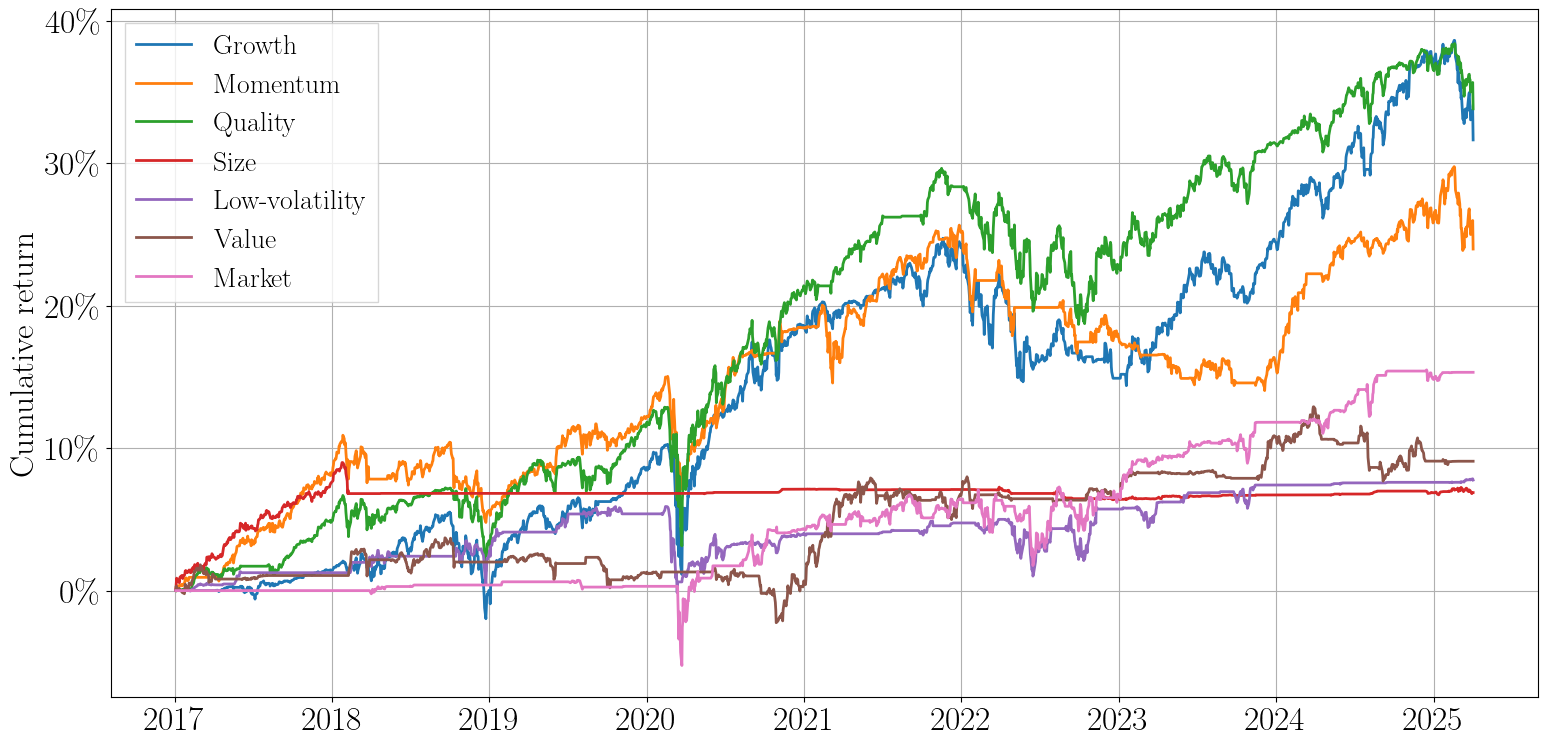

In [ ]:


import matplotlib.pyplot as plt

from jumpmodels.plot import plot_cumret_compounded, check_axes
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


def plot_factor_contributions(strategy_name, run_results, returns_df, factor_labels):

    w_view = run_results[strategy_name]["weights_actual"]

    exclude = set()
    if "Risk-Off" not in strategy_name:
        exclude |= {"rf"}


    factor_cols = [
        c for c in w_view.columns
        if c in returns_df.columns and c not in exclude
    ]


    r_df   = returns_df[factor_cols]
    w_view = w_view[factor_cols].reindex(r_df.index).ffill().fillna(0)


    contrib          = w_view.shift(1).mul(r_df)
    contrib.iloc[0]  = 0.0


    contrib = contrib.rename(columns=factor_labels)
    w_plot  = w_view.rename(columns=factor_labels)


    cumret = (1 + contrib).cumprod() - 1





    fig, ax = plt.subplots(figsize=(16, 8))


    for col in cumret.columns:
        ax.plot(cumret.index, cumret[col], label=col, linewidth=2)


    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for lab in labels:

        m = re.search(r"\(([^)]*)\)", lab)
        text = m.group(1) if m else lab

        text = re.sub(r"\bfactor\b", "", text, flags=re.IGNORECASE).strip()
        new_labels.append(text)
    ax.legend(handles, new_labels,
          loc="upper left",
          fontsize=20,
          frameon=True,
          fancybox=False)
    ax.grid(True)
    ax.set_ylabel("Cumulative return", fontsize=24)
    ax.tick_params(axis='both', labelsize=24)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    
    fig.tight_layout()


    
    plt.show()


chosen_strategy = "Long-Only (4 per cent TE)"  
plot_factor_contributions(chosen_strategy, run_results, test_df, factor_labels)



    


Strategy analysed : Risk-off 4% TE  ➜  Long-Only with Risk-Off (4 per cent TE)
Benchmark         : Benchmark (Q-Rebalanced EW)

Allocation added value  (eq 8a) : -2.33%
Static allocation value (eq 8b) : -1.40%
Dynamic allocation      (=8a−8b): -0.94%

        Allocation 8a  Static 8b   Dynamic
Market       0.001422  -0.000118  0.001541
iwf         -0.000519   0.000891 -0.001411
mtum        -0.001321   0.001074 -0.002395
qual         0.000782   0.000541  0.000241
rf          -0.035295  -0.023755 -0.011541
size         0.010366   0.006053  0.004313
usmv        -0.003029   0.000672 -0.003700
vlue         0.004267   0.000669  0.003597


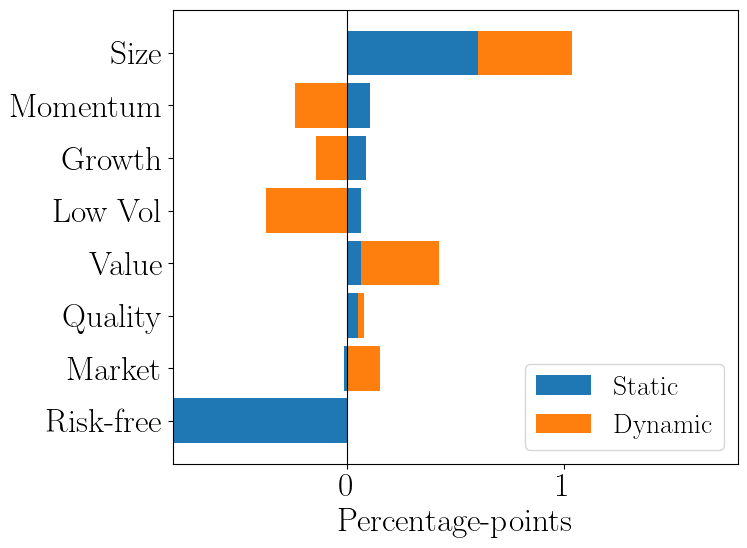

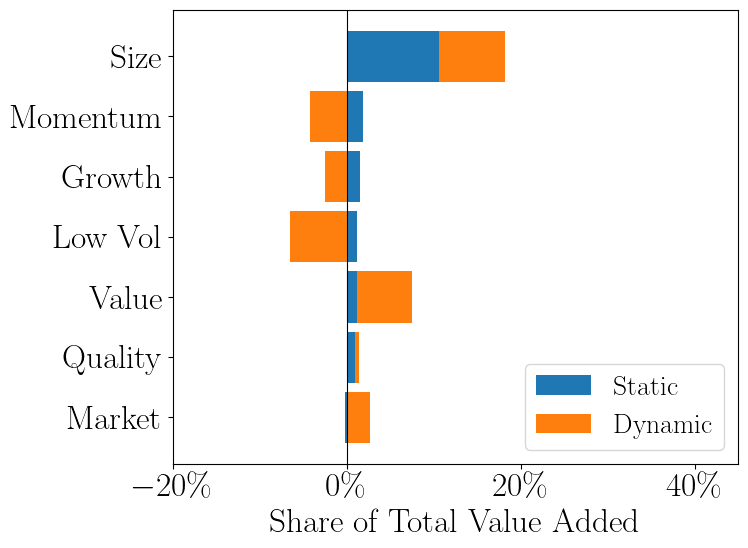

In [ ]:

import matplotlib.ticker as mtick

strategy_choice  = "Risk-off 4% TE"          
benchmark_choice = "Benchmark (Q-Rebalanced EW)"

strategy_label   = strategy_labels.get(strategy_choice,  strategy_choice)
benchmark_label  = strategy_labels.get(benchmark_choice, benchmark_choice)


w_port  = run_results[strategy_label]  \
            .get("weights_actual", run_results[strategy_label]["weights_view"])
w_bench = run_results[benchmark_label] \
            .get("weights_actual", run_results[benchmark_label]["weights_view"])


if 'rf' not in w_bench.columns:
    w_bench['rf'] = 0.0




w_port  = w_port.shift()
w_bench = w_bench.shift()


w_port  = w_port.iloc[1:]
w_bench = w_bench.iloc[1:]


factor_ret = test_df[w_port.columns].loc[w_port.index]



def hkm_allocation_effects(wp: pd.DataFrame,
                           wb: pd.DataFrame,
                           fr: pd.DataFrame):

    Rb_t = (wb * fr).sum(axis=1)               

    # --- eq 8a 
    alloc_term  = (wp - wb).mul(fr.sub(Rb_t, axis=0), axis=0)
    alloc_added = alloc_term.sum(axis=1).mean()

    # --- eq 8b  
    avg_wdiff   = (wp - wb).mean()
    avg_excess  = fr.sub(Rb_t, axis=0).mean()
    static_added = (avg_wdiff * avg_excess).sum()

    return alloc_added, static_added


def hkm_allocation_effects_breakdown(wp: pd.DataFrame,
                                     wb: pd.DataFrame,
                                     fr: pd.DataFrame):

    Rb_t = (wb * fr).sum(axis=1)

    # ----- eq 8a  
    alloc_term     = (wp - wb).mul(fr.sub(Rb_t, axis=0), axis=0)  
    alloc_series   = alloc_term.mean()       
    alloc_total    = alloc_series.sum()       

    # ----- eq 8b  
    avg_wdiff      = (wp - wb).mean()         
    avg_excess     = fr.sub(Rb_t, axis=0).mean()  
    static_series  = avg_wdiff * avg_excess  
    static_total   = static_series.sum()

    return alloc_total, static_total, alloc_series, static_series



alloc_val, static_val = hkm_allocation_effects(w_port, w_bench, factor_ret)
dynamic_val           = alloc_val - static_val

print(f"Strategy analysed : {strategy_choice}  ➜  {strategy_label}")
print(f"Benchmark         : {benchmark_choice}")
print()
print(f"Allocation added value  (eq 8a) : {alloc_val*252 : .2%}")
print(f"Static allocation value (eq 8b) : {static_val*252: .2%}")
print(f"Dynamic allocation      (=8a−8b): {dynamic_val*252: .2%}")


alloc_tot, static_tot, alloc_ser, static_ser = (
    hkm_allocation_effects_breakdown(w_port, w_bench, factor_ret)
)
dynamic_ser = alloc_ser - static_ser            
dynamic_tot = alloc_tot - static_tot           

annualise = 252
alloc_ser_yr   = alloc_ser   * annualise
static_ser_yr  = static_ser  * annualise
dynamic_ser_yr = dynamic_ser * annualise

breakdown = pd.DataFrame({
    "Allocation 8a": alloc_ser_yr,
    "Static 8b":    static_ser_yr,
    "Dynamic":      dynamic_ser_yr
})

print()
print(breakdown)

plt.rcParams.update({'font.size': 20})


factor_labels_attrib = {
    "iwf":  "Growth",
    "mtum": "Momentum",
    "qual": "Quality",
    "size": "Size",
    "usmv": "Low Vol",
    "vlue": "Value",
    "Market": "Market",
    "rf":     "Risk-free"
}


df_attrib = pd.DataFrame({
    "Static": static_ser_yr * 100,
    "Dynamic":     dynamic_ser_yr * 100,
})


df_attrib.index = df_attrib.index.map(lambda x: factor_labels_attrib.get(x, x))




df_attrib = df_attrib.sort_values("Static", ascending=True)


static  = df_attrib["Static"].values
dynamic = df_attrib["Dynamic"].values


left_dyn = np.where(np.sign(static)==np.sign(dynamic), static, 0)

fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 24})
bar_w = 0.85
y     = np.arange(len(df_attrib))

ax.barh(y, static,  bar_w, label="Static")
ax.barh(y, dynamic, bar_w, left=left_dyn, label="Dynamic")

ax.set_yticks(y)
ax.set_yticklabels(df_attrib.index, fontsize=24)
ax.set_xlabel("Percentage-points", fontsize=24)
ax.axvline(0, color="black", linewidth=0.8)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20, loc="lower right")
ax.margins(x=0.05)
ax.set_xbound(-0.8, 1.8)
plt.tight_layout()
plt.show()


total_contrib = df_attrib["Static"] + df_attrib["Dynamic"]


total_value = total_contrib.abs().sum()
df_share = pd.DataFrame({
    "Static %":  df_attrib["Static"]  / total_value*100,
    "Dynamic %": df_attrib["Dynamic"] / total_value*100 
})

df_share = df_share.drop(index="Risk-free", errors="ignore")

static  = df_share["Static %"].values
dynamic = df_share["Dynamic %"].values
left_dyn = np.where(np.sign(static)==np.sign(dynamic), static, 0)


y = np.arange(len(df_share))
fig, ax = plt.subplots(figsize=(8,6))


ax.barh(y, static, 0.85, label="Static")

ax.barh(y, dynamic, 0.85, left=left_dyn, label="Dynamic")

ax.set_yticks(y)
ax.set_yticklabels(df_share.index, fontsize=24)
ax.set_xlabel("Share of Total Value Added", fontsize=24)
ax.axvline(0, color="black", linewidth=0.8)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20, loc="lower right")
ax.margins(x=0.05)
ax.set_xbound(-20, 45)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.tight_layout()
plt.show()

In [ ]:


import numpy as np
from scipy import stats


def _moments(x):
    μ  = x.mean()
    σ  = x.std(ddof=1)         
    m3 = ((x - μ) ** 3).mean()
    m4 = ((x - μ) ** 4).mean()
    γ3, γ4 = m3 / σ**3, m4 / σ**4
    return μ, σ, γ3, γ4


def _var_sr(μ, σ, γ3, γ4, SR, T):

    return ((γ4 - 1) - 2 * SR * γ3 + (γ4 - 1) * SR**2) / (4 * T)


def _cross_moments(a, b):

    n   = len(a)
    da  = a - a.mean()
    db  = b - b.mean()

    s1a = da.sum();              s1b = db.sum()
    s2a = (da ** 2).sum();       s2b = (db ** 2).sum()
    s11 = (da * db).sum()

    μ22 = (n * s2a * s2b - (n + 1) * s2a * s2b + 2 * s11**2) / (n * (n - 1) * (n - 2) * (n - 3))
    μ12 = (n * (da * db**2).sum() - 2 * s1a * s2b - s1b * s11) / (n * (n - 1) * (n - 2))
    μ21 = (n * (db * da**2).sum() - 2 * s1b * s2a - s1a * s11) / (n * (n - 1) * (n - 2))
    return μ22, μ12, μ21


def opdyke_z(a, b, rf=0.0, periods=252):
    ra = np.asarray(a) - np.asarray(rf)
    rb = np.asarray(b) - np.asarray(rf)
    mask = ~np.isnan(ra) & ~np.isnan(rb)
    ra, rb = ra[mask], rb[mask]
    T = len(ra)

    μa, σa, γ3a, γ4a = _moments(ra)
    μb, σb, γ3b, γ4b = _moments(rb)
    SRa, SRb = μa / σa, μb / σb

    Va = _var_sr(μa, σa, γ3a, γ4a, SRa, T)
    Vb = _var_sr(μb, σb, γ3b, γ4b, SRb, T)

    μ22, μ12, μ21 = _cross_moments(ra, rb)
    ρ = np.corrcoef(ra, rb)[0, 1]


    Cab = (
        μ22 / (4 * σa**2 * σb**2)
        - SRa * μ12 / (2 * σa * σb**2)
        - SRb * μ21 / (2 * σa**2 * σb)
        + ρ * SRa * SRb            
    ) / T

    denom = Va + Vb - 2 * Cab

    se_diff = np.sqrt(denom * periods)
    if denom <= 0:
        return (
            SRa * np.sqrt(periods),
            SRb * np.sqrt(periods),
            se_diff,
            np.nan,
            np.nan,
        )

    z = (SRa - SRb) / np.sqrt(denom)
    p = 1 * (1 - stats.norm.cdf(abs(z)))
    return (
        SRa * np.sqrt(periods),
        SRb * np.sqrt(periods),
        se_diff,
        z,
        p,
    )

bench = ew_rets
rf_daily = etf_df["rf"].reindex(full_idx).fillna(0)
for name, res in run_results.items():
    sr_a, sr_b, se_diff, z, p = opdyke_z(
        res["returns"],
        bench,
        rf=rf_daily,      
    )
    print(
        f"{name:30s}  "
        f"SR₁={sr_a:.3f}, SR₂={sr_b:.3f}, ΔSR={sr_a-sr_b:+.3f}, "
        f"Std.Err.(diff)={se_diff:.3f}, z={z:+.2f}, p={p:.3f}"
    )

Long-Only (4 per cent TE)       SR₁=0.596, SR₂=0.527, ΔSR=+0.069, Std.Err.(diff)=0.999, z=+0.07, p=0.473
Long-Only (3 per cent TE)       SR₁=0.577, SR₂=0.527, ΔSR=+0.050, Std.Err.(diff)=1.008, z=+0.05, p=0.480
Long-Only (2 per cent TE)       SR₁=0.568, SR₂=0.527, ΔSR=+0.041, Std.Err.(diff)=1.010, z=+0.04, p=0.484
Long-Only (1 per cent TE)       SR₁=0.564, SR₂=0.527, ΔSR=+0.037, Std.Err.(diff)=1.019, z=+0.04, p=0.486
Long-Short (4 per cent TE)      SR₁=0.555, SR₂=0.527, ΔSR=+0.028, Std.Err.(diff)=0.995, z=+0.03, p=0.489
Long-Short (3 per cent TE)      SR₁=0.554, SR₂=0.527, ΔSR=+0.028, Std.Err.(diff)=1.002, z=+0.03, p=0.489
Long-Short (2 per cent TE)      SR₁=0.564, SR₂=0.527, ΔSR=+0.037, Std.Err.(diff)=1.009, z=+0.04, p=0.485
Long-Short (1 per cent TE)      SR₁=0.562, SR₂=0.527, ΔSR=+0.036, Std.Err.(diff)=1.020, z=+0.03, p=0.486
Long-Only with Risk-Off (4 per cent TE)  SR₁=0.565, SR₂=0.527, ΔSR=+0.038, Std.Err.(diff)=0.887, z=+0.04, p=0.483
Long-Only with Risk-Off (3 per cent TE)  SR₁=0

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy import stats
import scipy.stats as ss

def pick_nw_lags(series, max_lags=20, alpha=0.05):
    x = np.asarray(series)
    T = len(x)
    acfs = acf(x, nlags=max_lags, fft=False)
    bound = ss.norm.ppf(1 - alpha/2) / np.sqrt(T)
    sig = np.where(np.abs(acfs[1:]) > bound)[0] + 1
    return int(sig.max()) if sig.size else 0

def nw_lag_rule(T: int) -> int:

    return max(1, int(np.floor(4 * (T / 100) ** (2 / 9))))

def test_active_return_vs_benchmark(
    strategy_returns,
    benchmark_returns,
    max_check_lags: int = 20,
    alpha: float = 0.05
):

    strat = pd.Series(strategy_returns)
    bench = pd.Series(benchmark_returns)
    strat, bench = strat.align(bench, join="inner")
    active = strat - bench
    T = len(active)


    opt_lags =  nw_lag_rule(T)


    lb = acorr_ljungbox(active, lags=[opt_lags], return_df=True)
    lb_flag = lb["lb_pvalue"].iloc[0] < alpha


    X = np.ones((T, 1))         
    model = sm.OLS(active, X)
    results = model.fit(cov_type="HAC", cov_kwds={"maxlags": opt_lags})


    mean_ann = active.mean() * 252 * 100
    se_ann   = results.bse.iloc[0] * 252 * 100

    p_value = stats.t.sf(results.tvalues.iloc[0], df=results.df_resid)

    return {
        "mean_active_return": mean_ann,
        "std_err": se_ann,
        "t_stat": results.tvalues.iloc[0],
        "p_value": p_value,
        "ljungbox_detected": lb_flag,
        "hac_lags_used": opt_lags
    }



ew = run_results["Benchmark (Q-Rebalanced EW)"]["returns"]
for name, res in run_results.items():
    if "Benchmark" in name:
        continue

    metrics = test_active_return_vs_benchmark(res["returns"], ew)
    print(
        f"{name:35s} Δμ={metrics['mean_active_return']:+.3f}%  "
        f"SE={metrics['std_err']:+.3f}%  t={metrics['t_stat']:+.3f}  "
        f"p={metrics['p_value']:.3f}  "
        f"lags={metrics['hac_lags_used']:.1f}"
    )


Long-Only (4 per cent TE)           Δμ=+1.617%  SE=+1.028%  t=+1.572  p=0.058  lags=7.0
Long-Only (3 per cent TE)           Δμ=+1.044%  SE=+0.924%  t=+1.130  p=0.129  lags=7.0
Long-Only (2 per cent TE)           Δμ=+0.528%  SE=+0.789%  t=+0.669  p=0.252  lags=7.0
Long-Only (1 per cent TE)           Δμ=+0.190%  SE=+0.655%  t=+0.290  p=0.386  lags=7.0
Long-Short (4 per cent TE)          Δμ=+0.978%  SE=+1.296%  t=+0.755  p=0.225  lags=7.0
Long-Short (3 per cent TE)          Δμ=+0.581%  SE=+1.075%  t=+0.540  p=0.295  lags=7.0
Long-Short (2 per cent TE)          Δμ=+0.395%  SE=+0.866%  t=+0.456  p=0.324  lags=7.0
Long-Short (1 per cent TE)          Δμ=+0.151%  SE=+0.675%  t=+0.224  p=0.412  lags=7.0
Long-Only with Risk-Off (4 per cent TE) Δμ=-2.879%  SE=+4.562%  t=-0.631  p=0.736  lags=7.0
Long-Only with Risk-Off (3 per cent TE) Δμ=-3.204%  SE=+4.548%  t=-0.705  p=0.759  lags=7.0
Long-Only with Risk-Off (2 per cent TE) Δμ=-3.525%  SE=+4.533%  t=-0.778  p=0.782  lags=7.0
Long-Only with Risk-

                            CAPM beta
Strategy                             
Long-Only (4 per cent TE)       0.979
Long-Short (4 per cent TE)      0.984
Long-Only (1 per cent TE)       0.907
Long-Short (1 per cent TE)      0.905


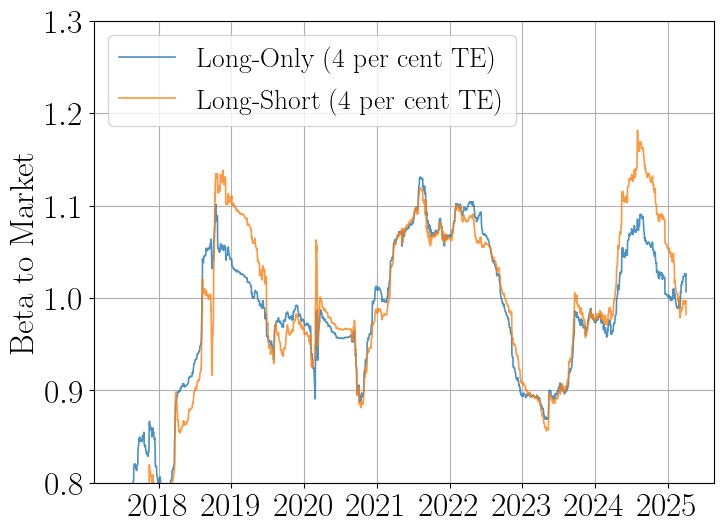

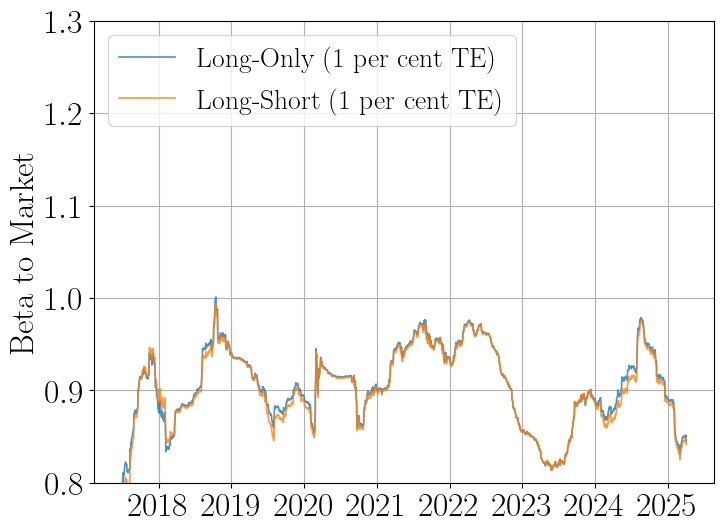

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def capm_beta(port_ret, mkt_ret):

    y, x = port_ret.align(mkt_ret, join="inner")
    x = sm.add_constant(x)           
    model = sm.OLS(y, x, missing="drop").fit()

    return model.params.drop("const").iloc[0]




pairs = [
    ("Long-Only (4 per cent TE)",  "Long-Short (4 per cent TE)"),
    ("Long-Only (1 per cent TE)",  "Long-Short (1 per cent TE)"),

]

mkt = etf_df["Market"].loc[full_idx] - etf_df["rf"].loc[full_idx]   

results = []

for long_only, long_short in pairs:
    for lab in (long_only, long_short):
        r  = run_results[lab]["returns"]     
        rex = r - etf_df["rf"].reindex(r.index)  
        beta = capm_beta(rex, mkt)
        results.append({"Strategy": lab, "CAPM beta": beta})

df_beta = pd.DataFrame(results).set_index("Strategy")
print(df_beta.round(3))


window = 126     

for long_only, long_short in pairs:
    fig, ax = plt.subplots(figsize=(8, 6))

    for lab, color in [(long_only, "tab:blue"), (long_short, "tab:orange")]:
        r = run_results[lab]["returns"]
        rex = r - etf_df["rf"].reindex(r.index)
        roll_beta = (
            rex.rolling(window)
               .cov(mkt)
               / mkt.rolling(window).var()
        )
        ax.plot(roll_beta.index, roll_beta.values, label=lab, color=color, alpha=0.8, lw=1.2)

    ax.axhline(0, color="grey", ls="--", linewidth=1.5)
    ax.set_ylabel("Beta to Market", fontsize=24)
    ax.set_xlabel("", fontsize=20)
    ax.set_ylim(0.8, 1.3)
    
    ax.legend(loc="upper left", fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=24)

    plt.show()



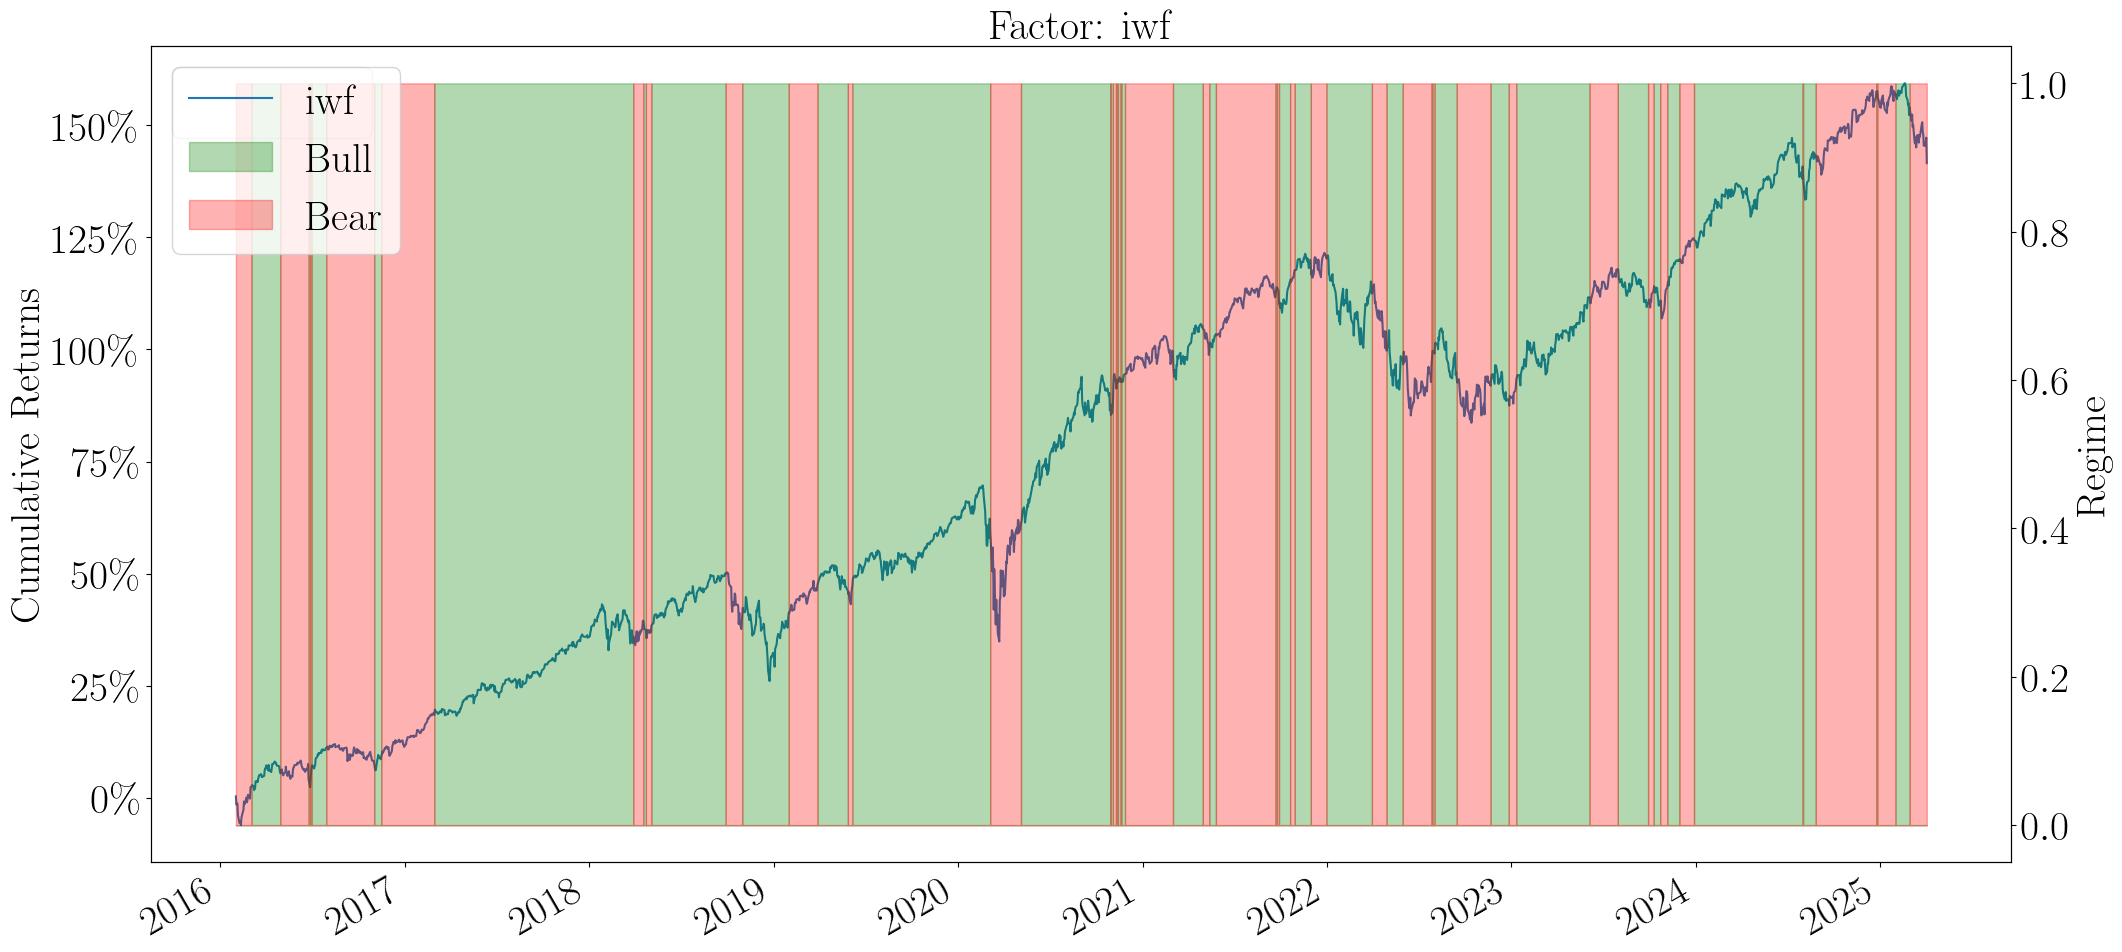

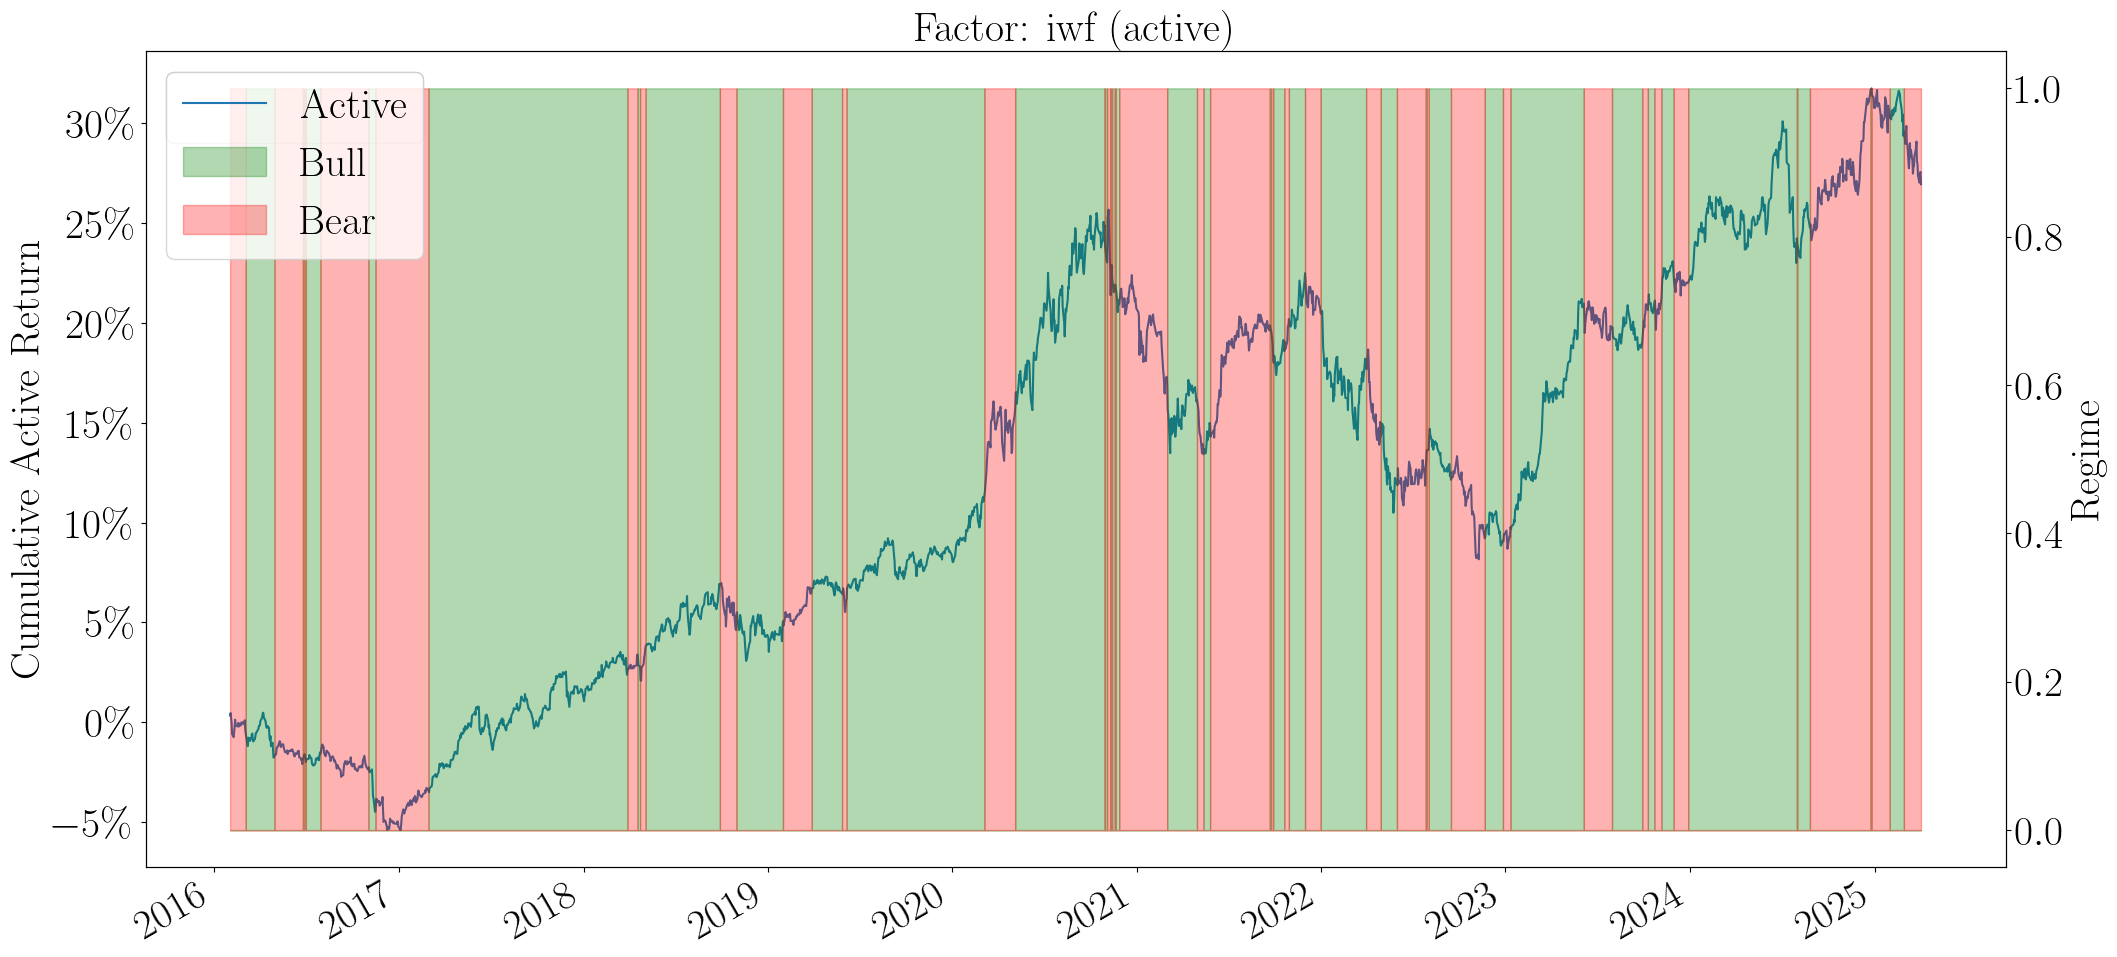

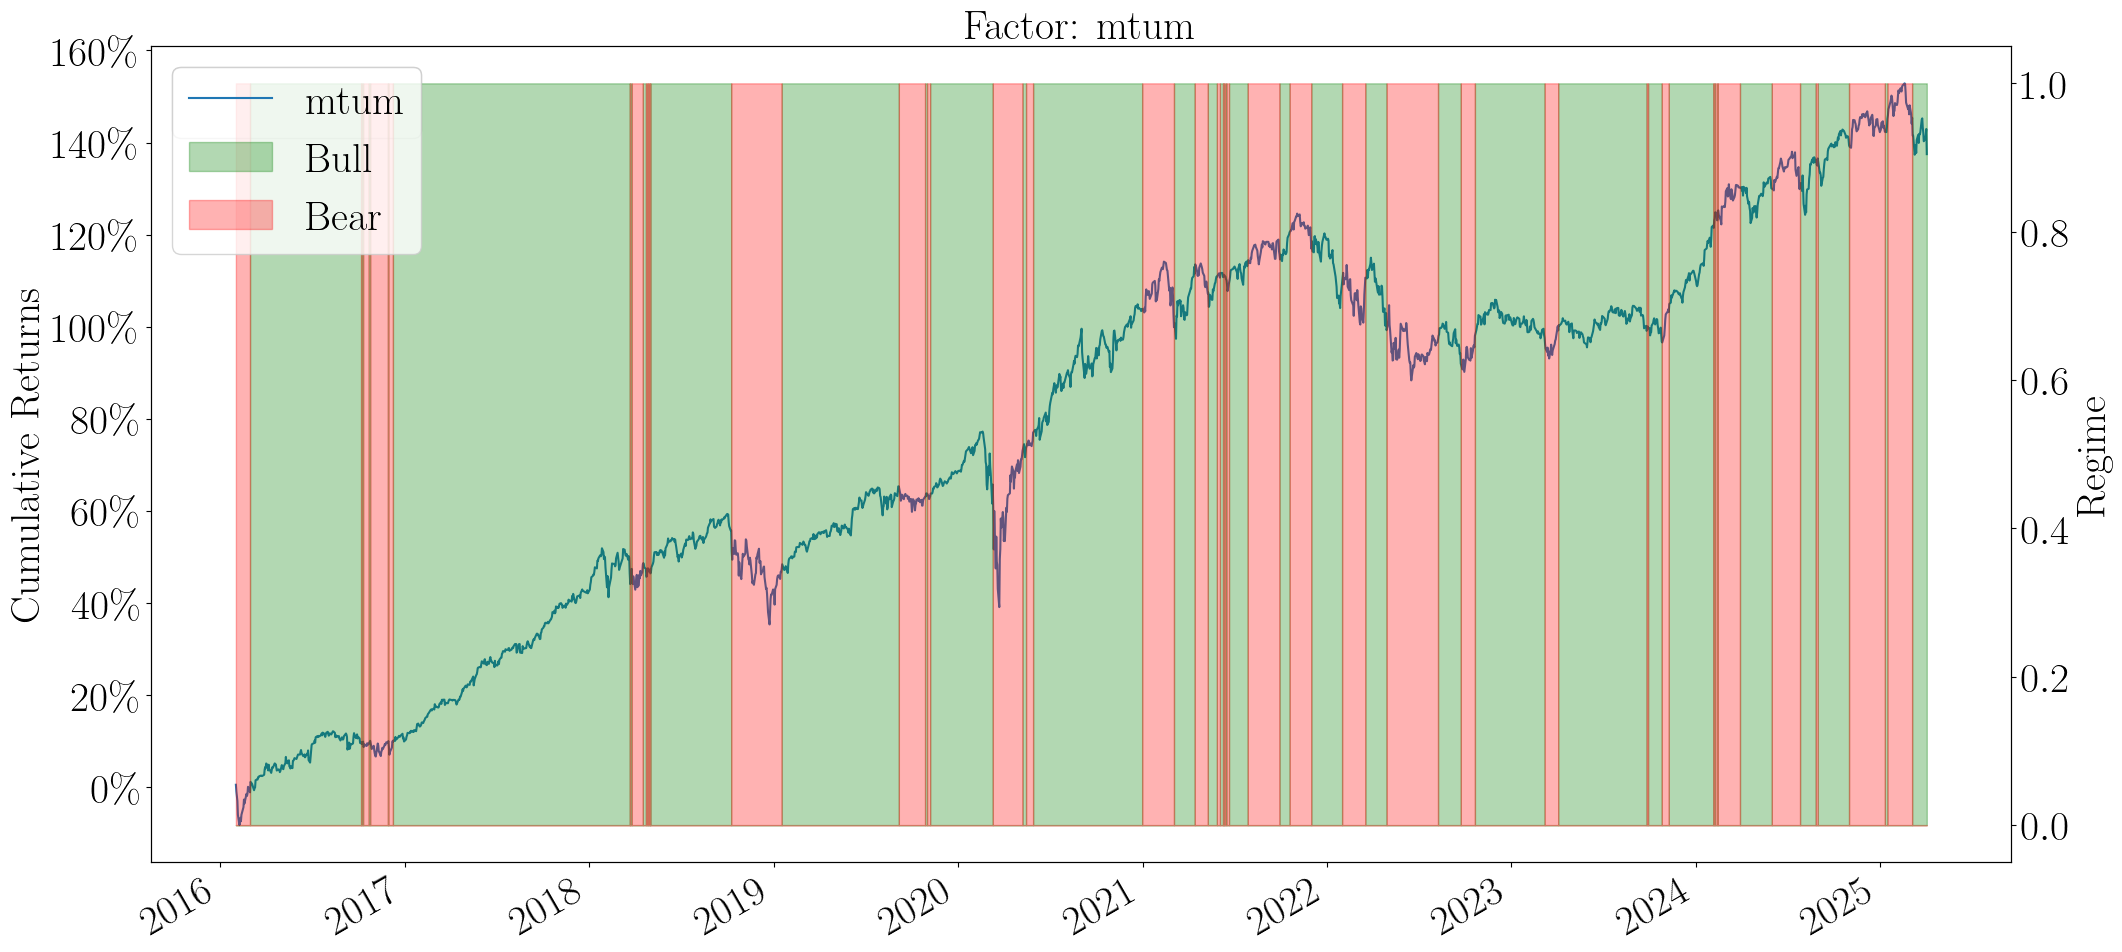

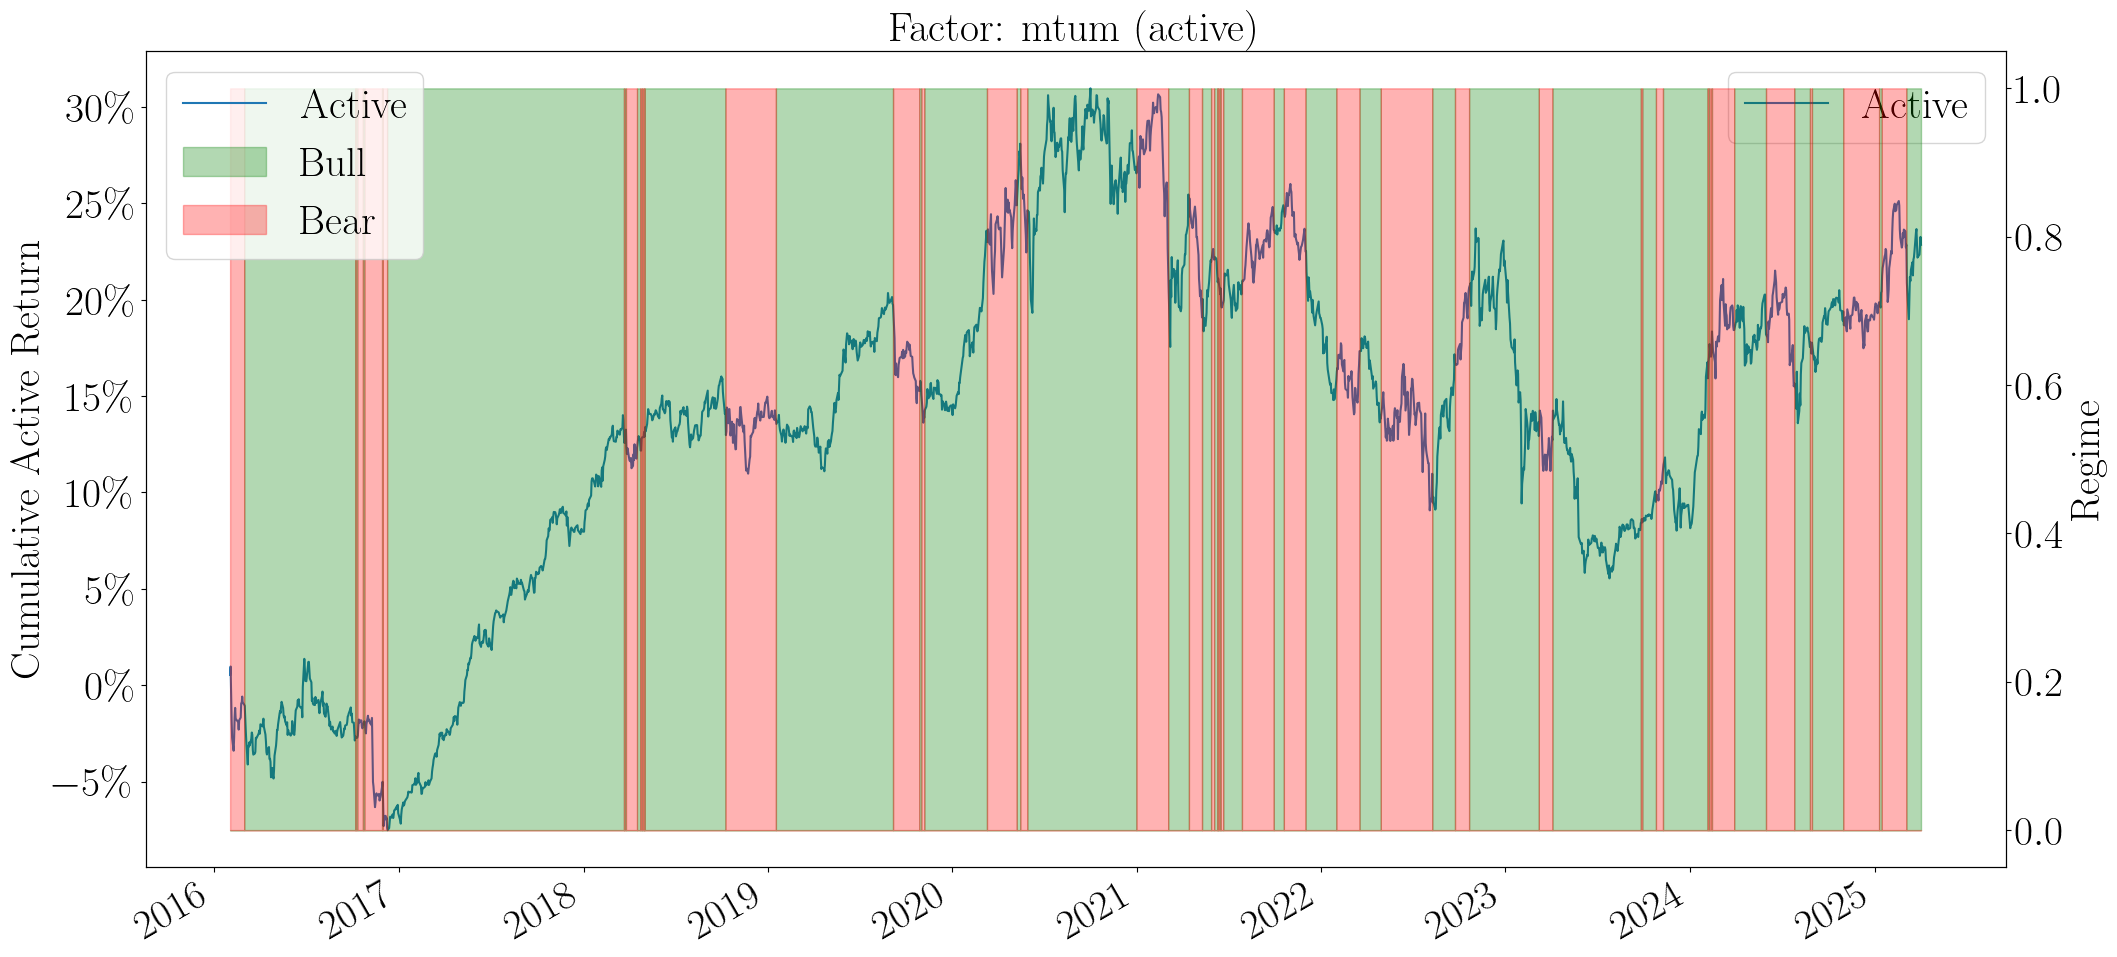

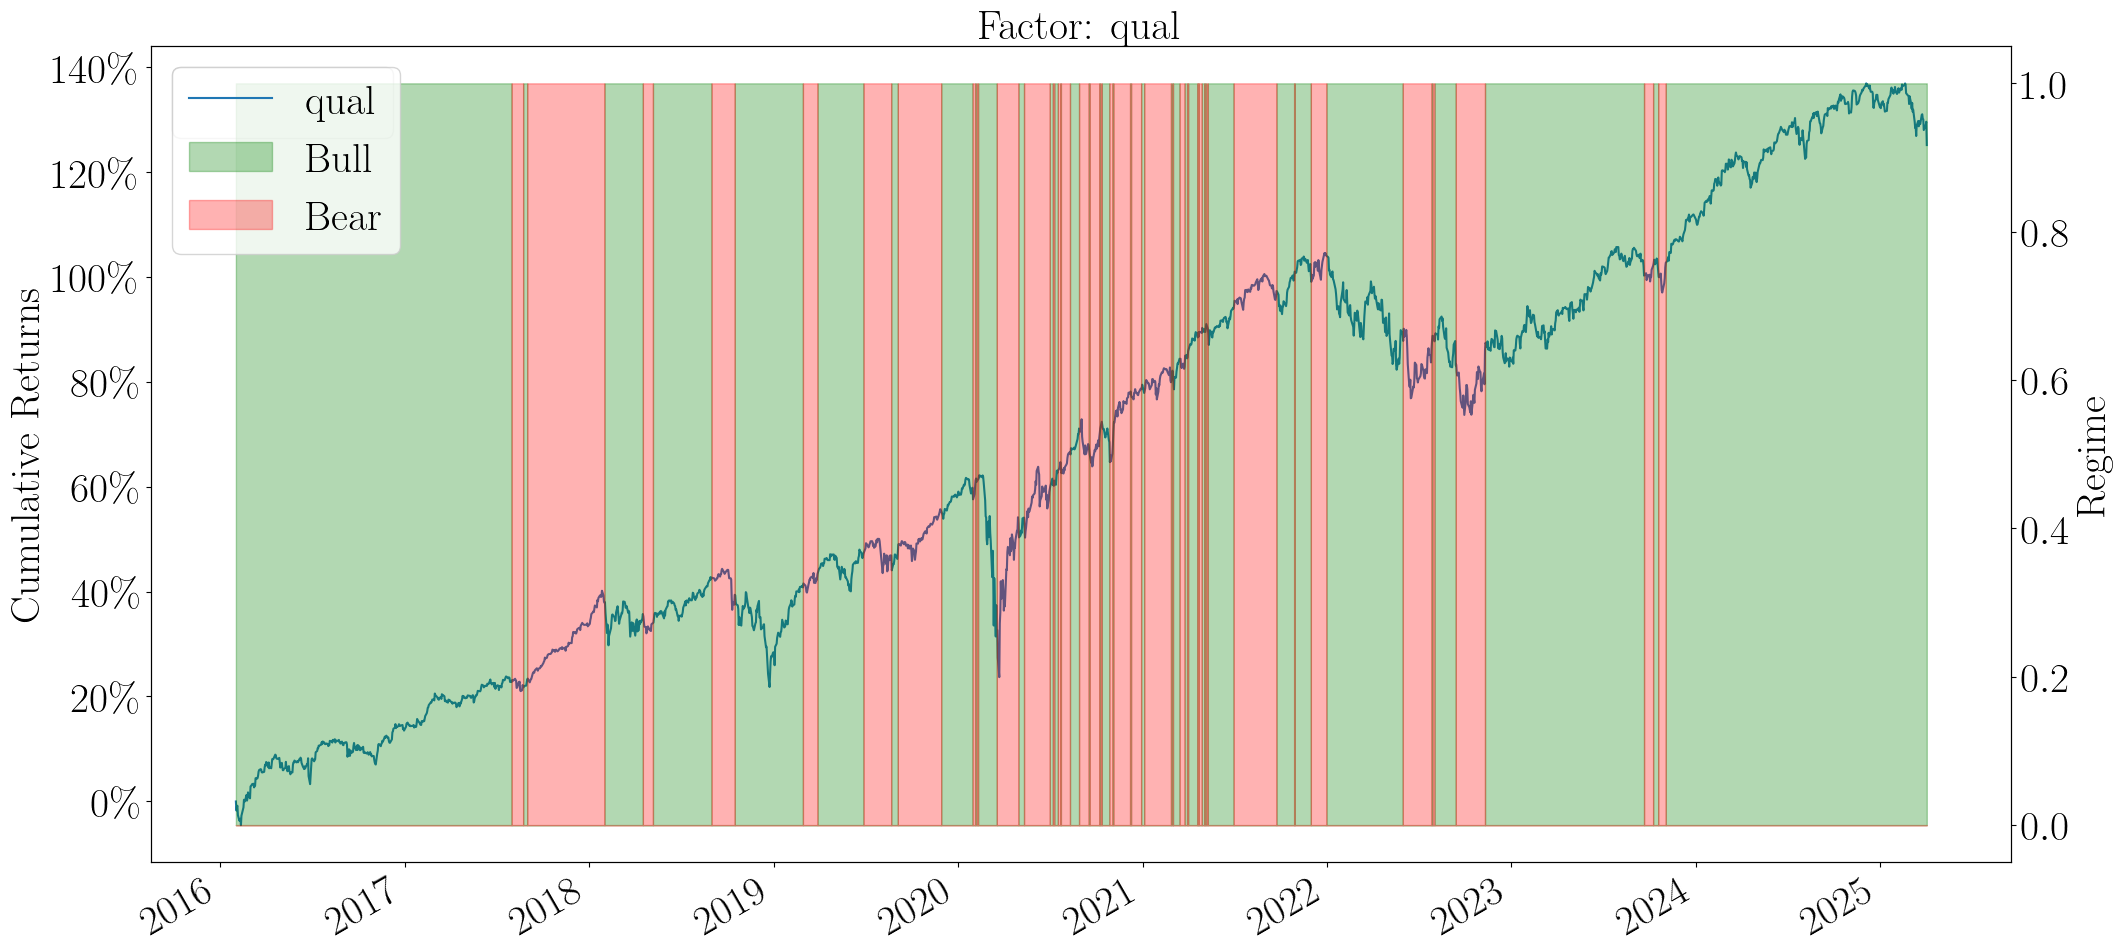

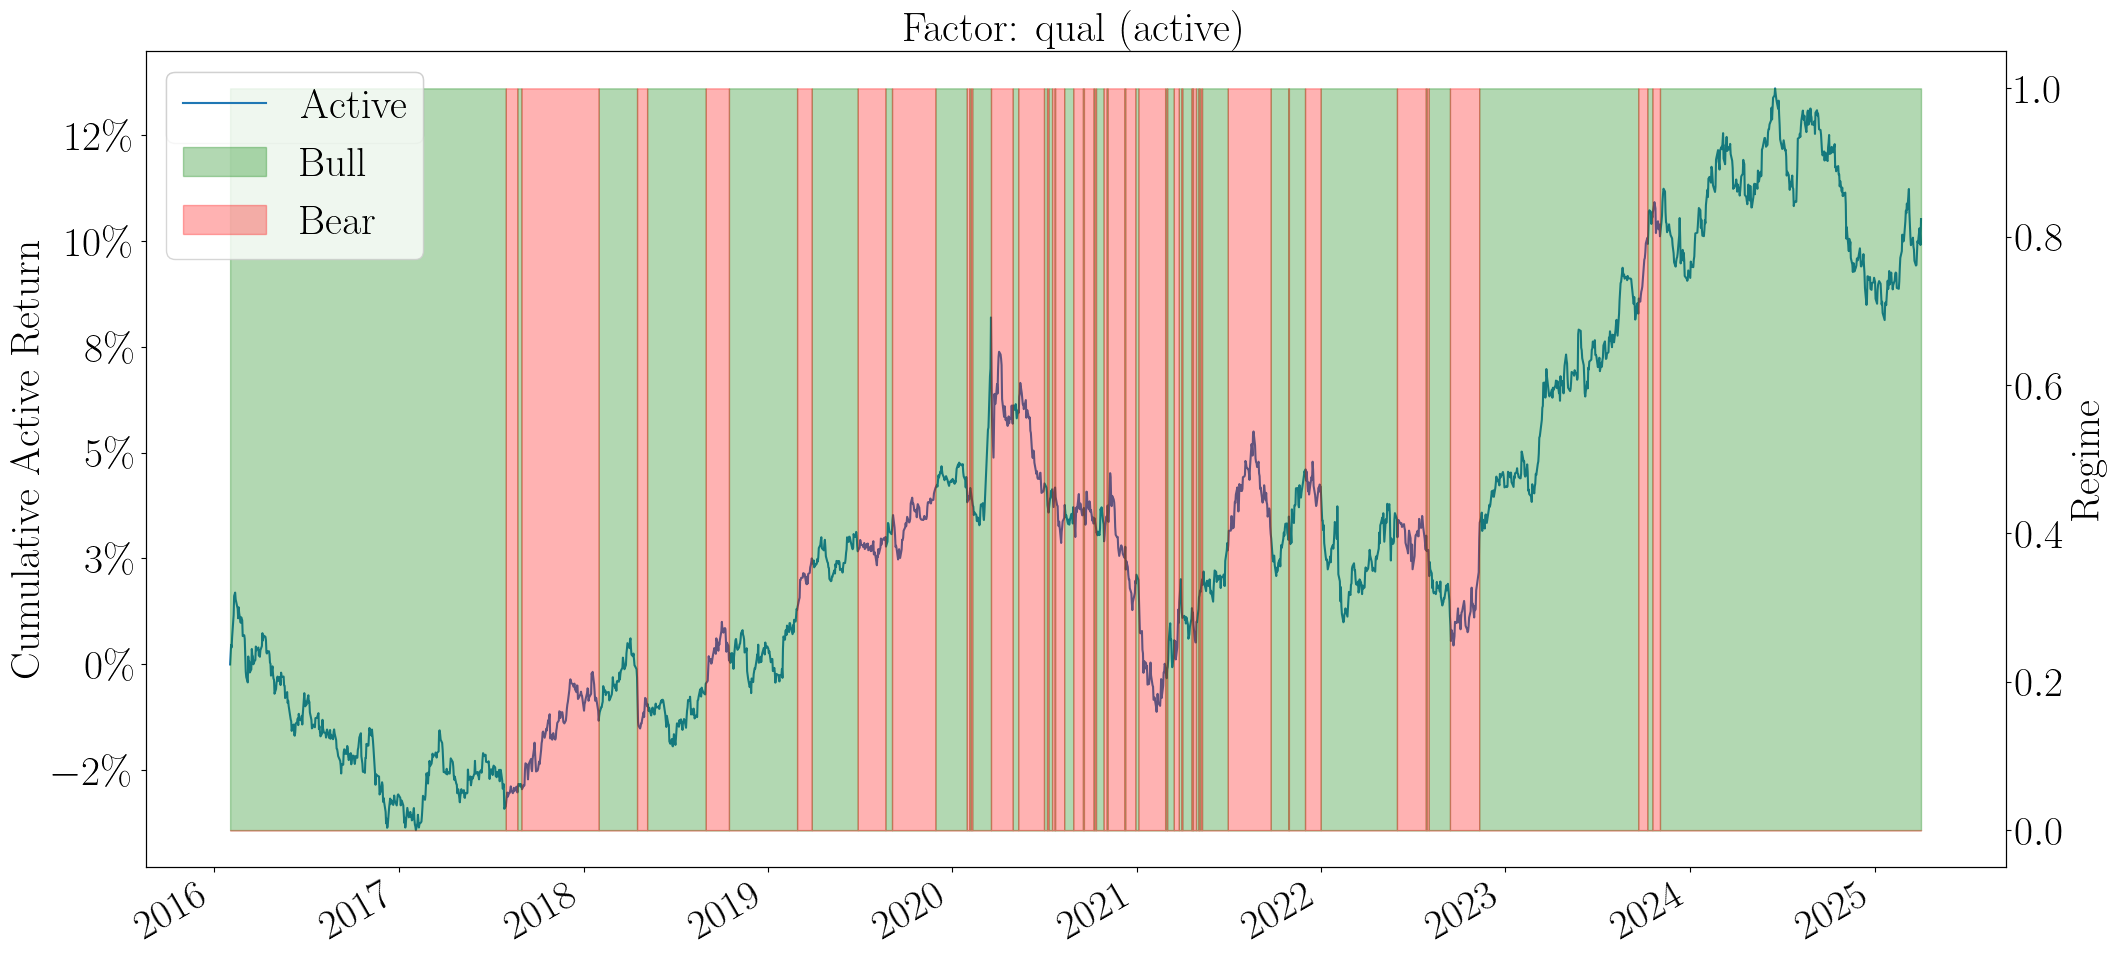

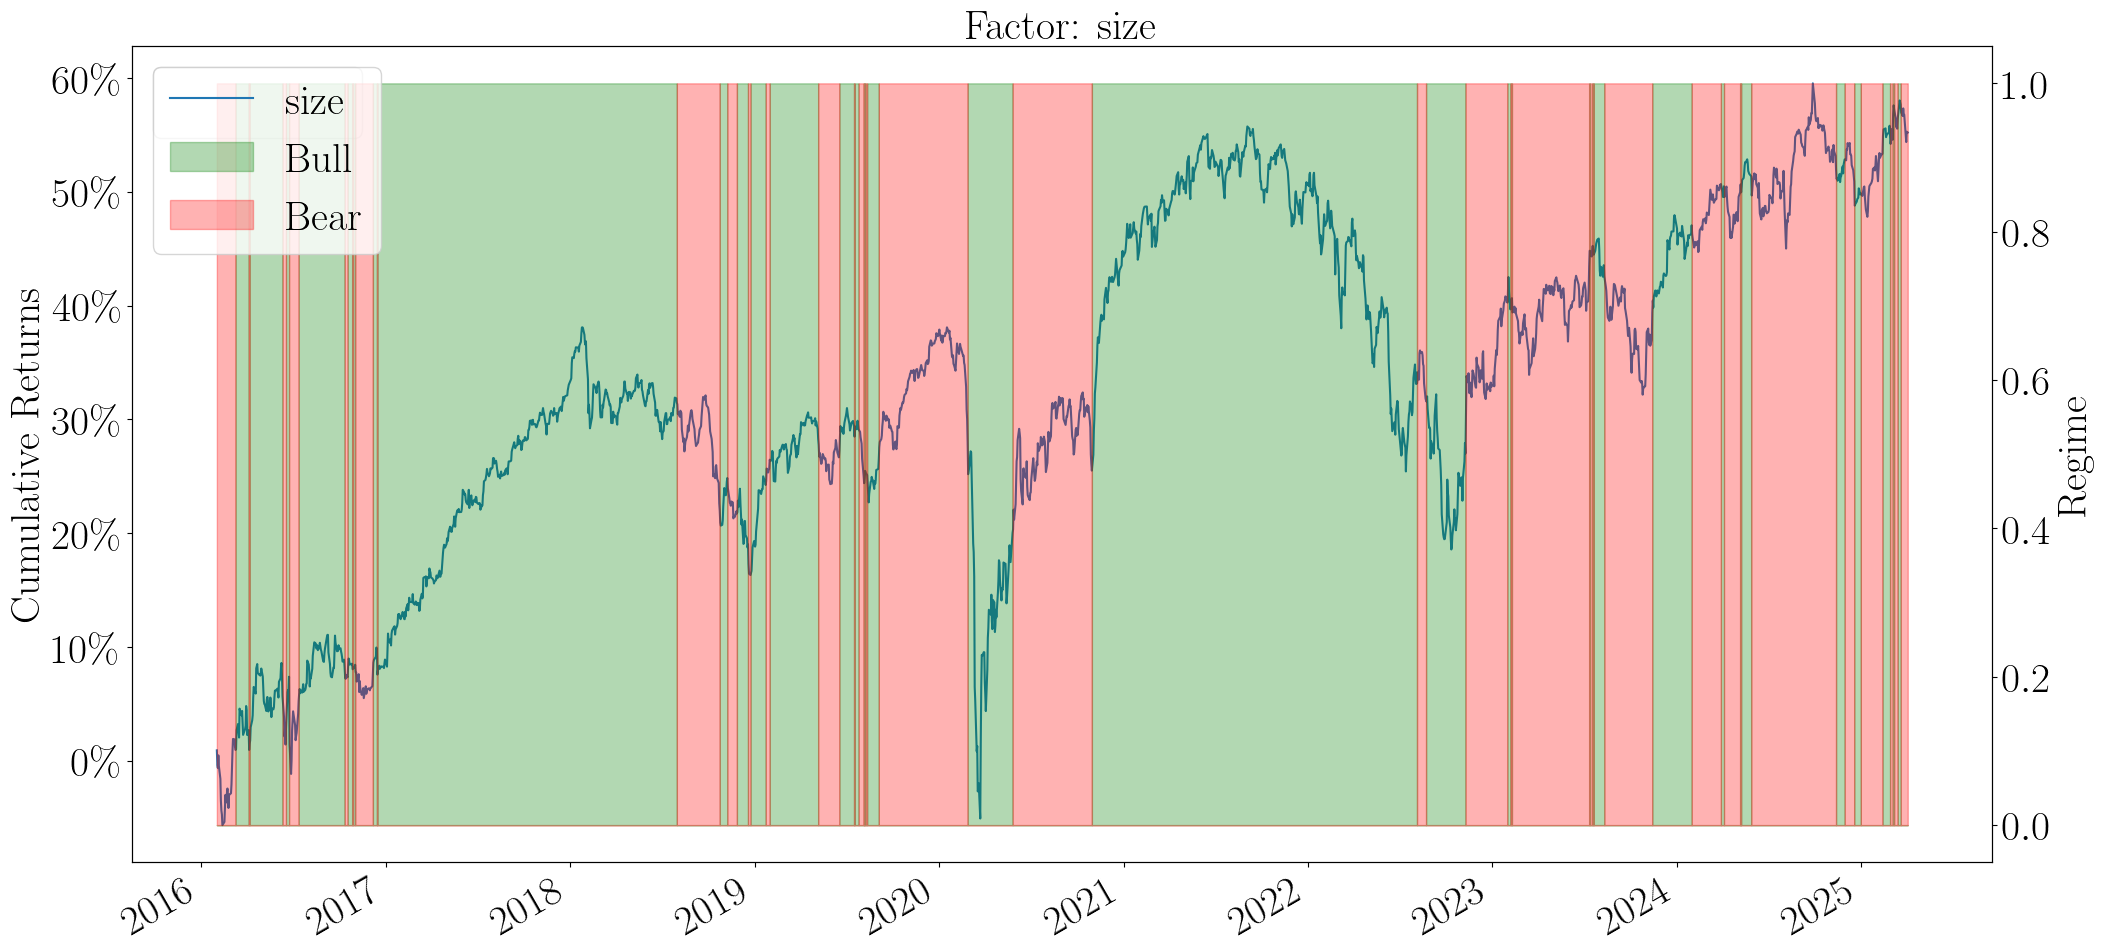

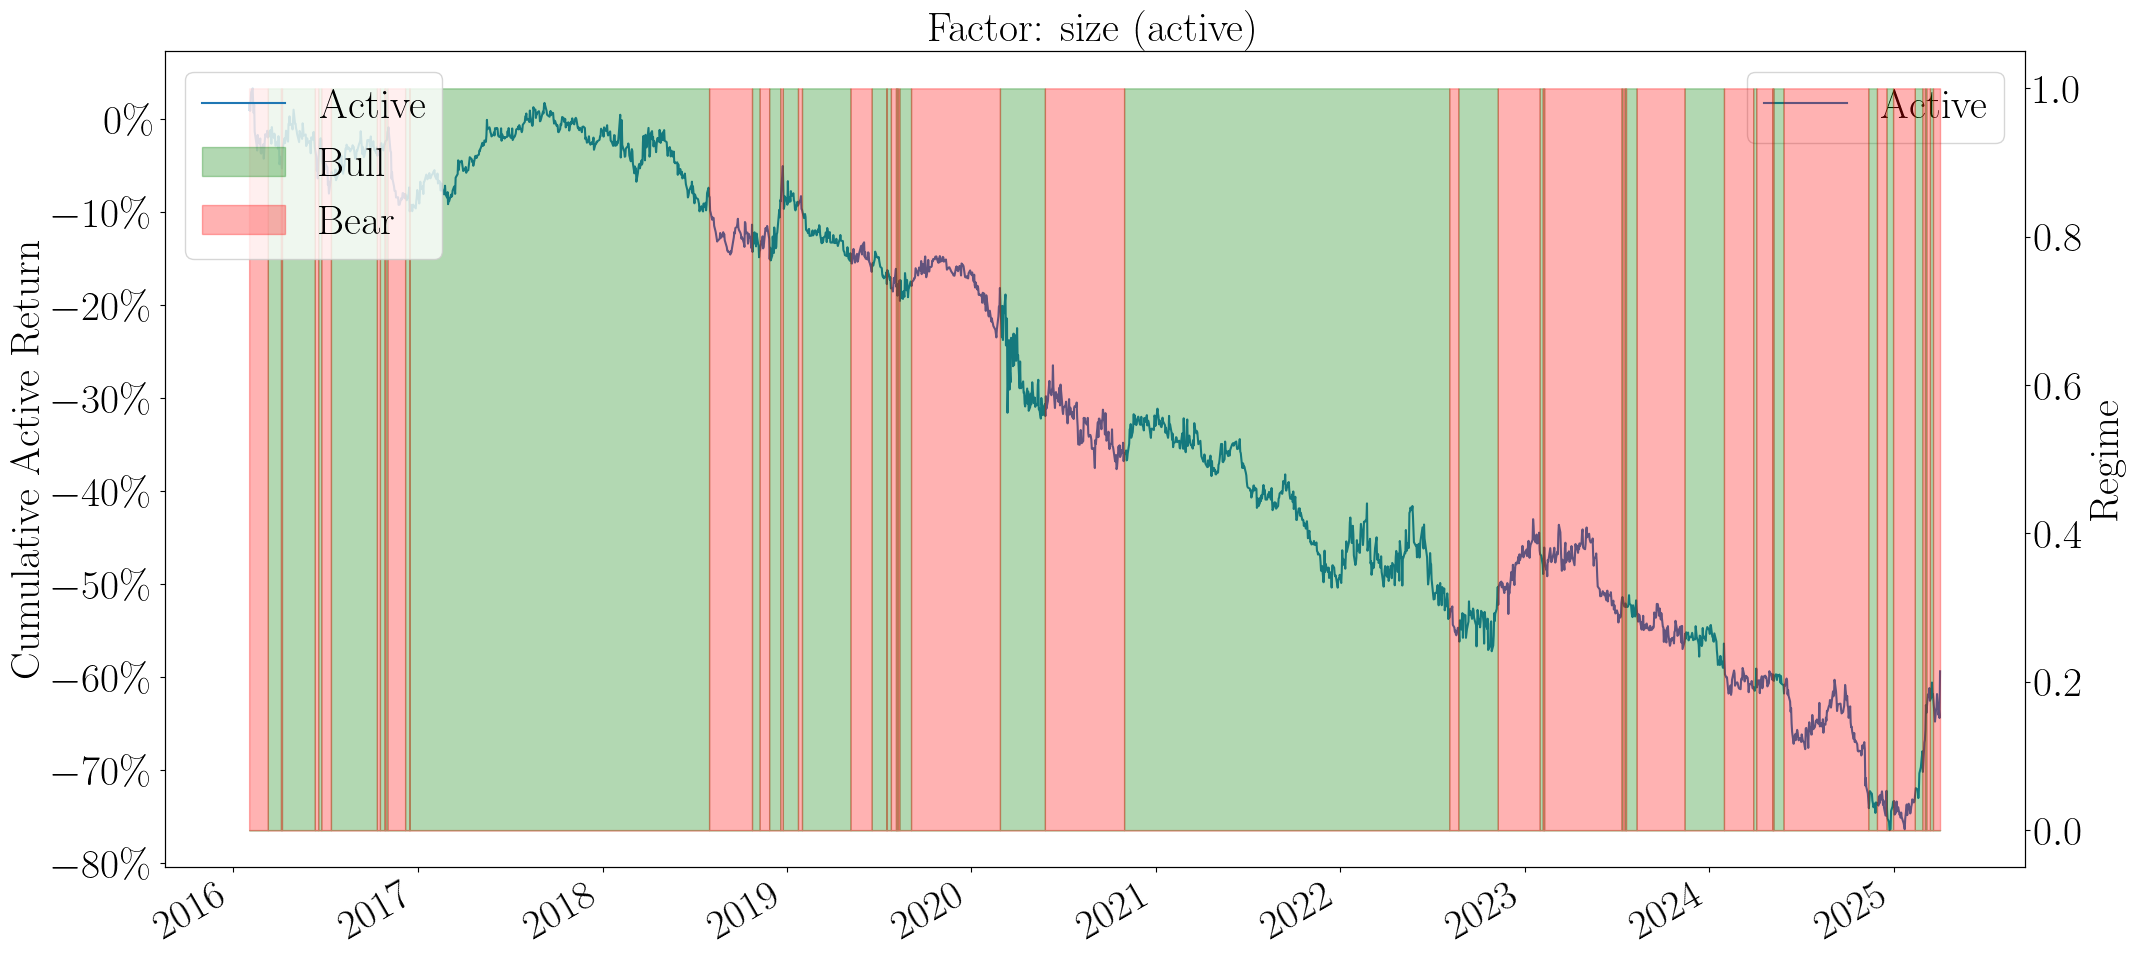

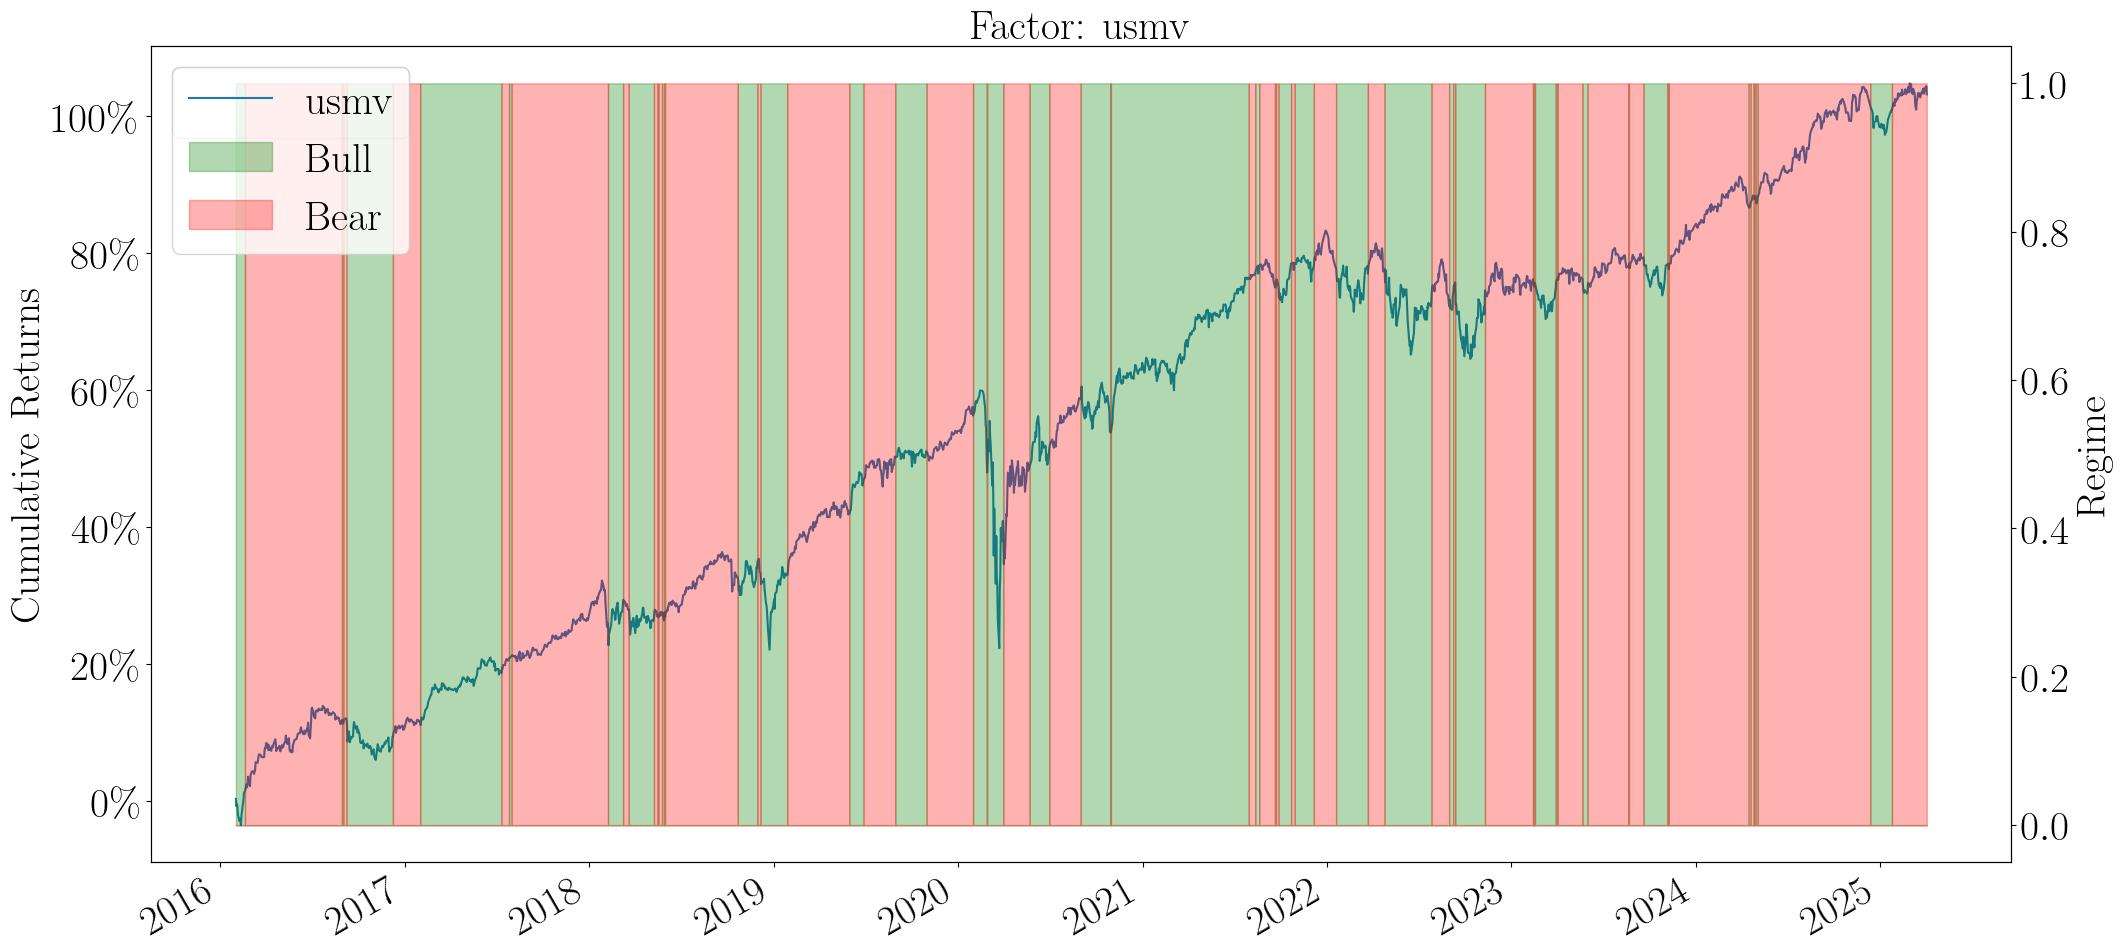

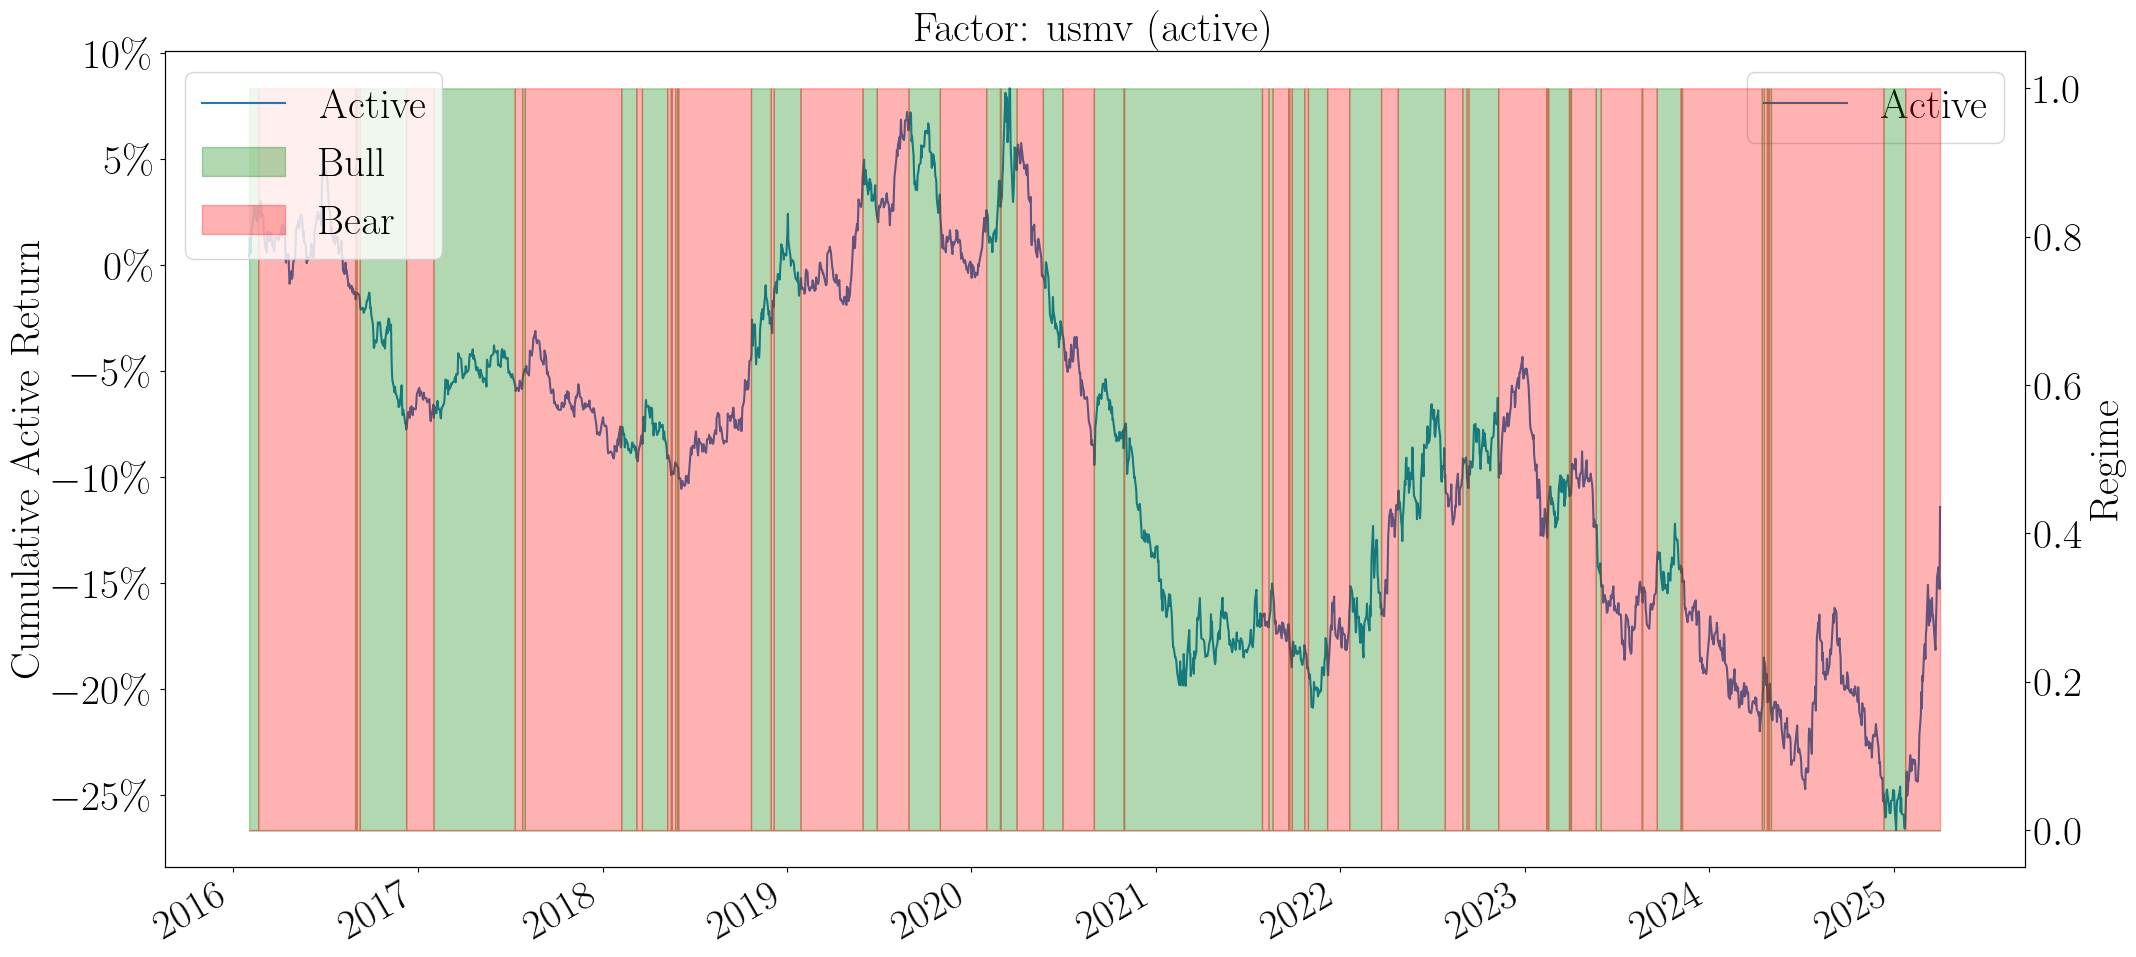

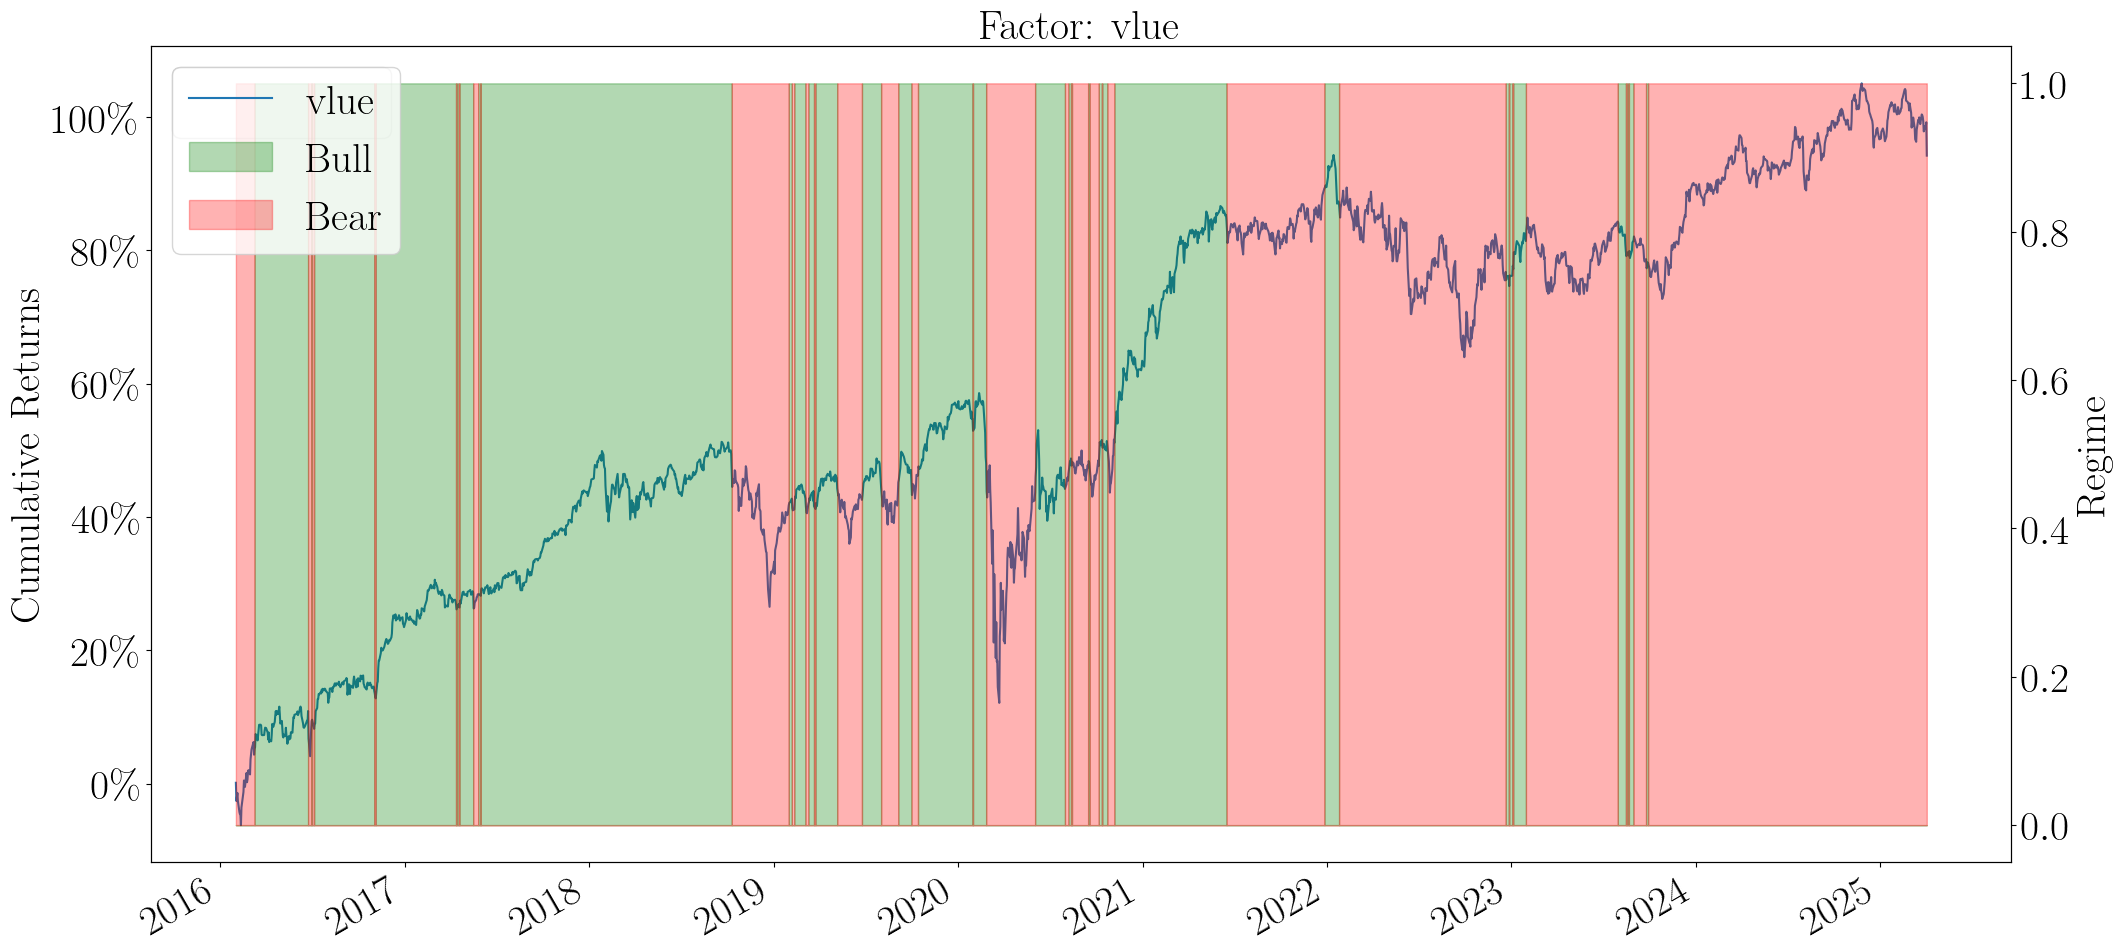

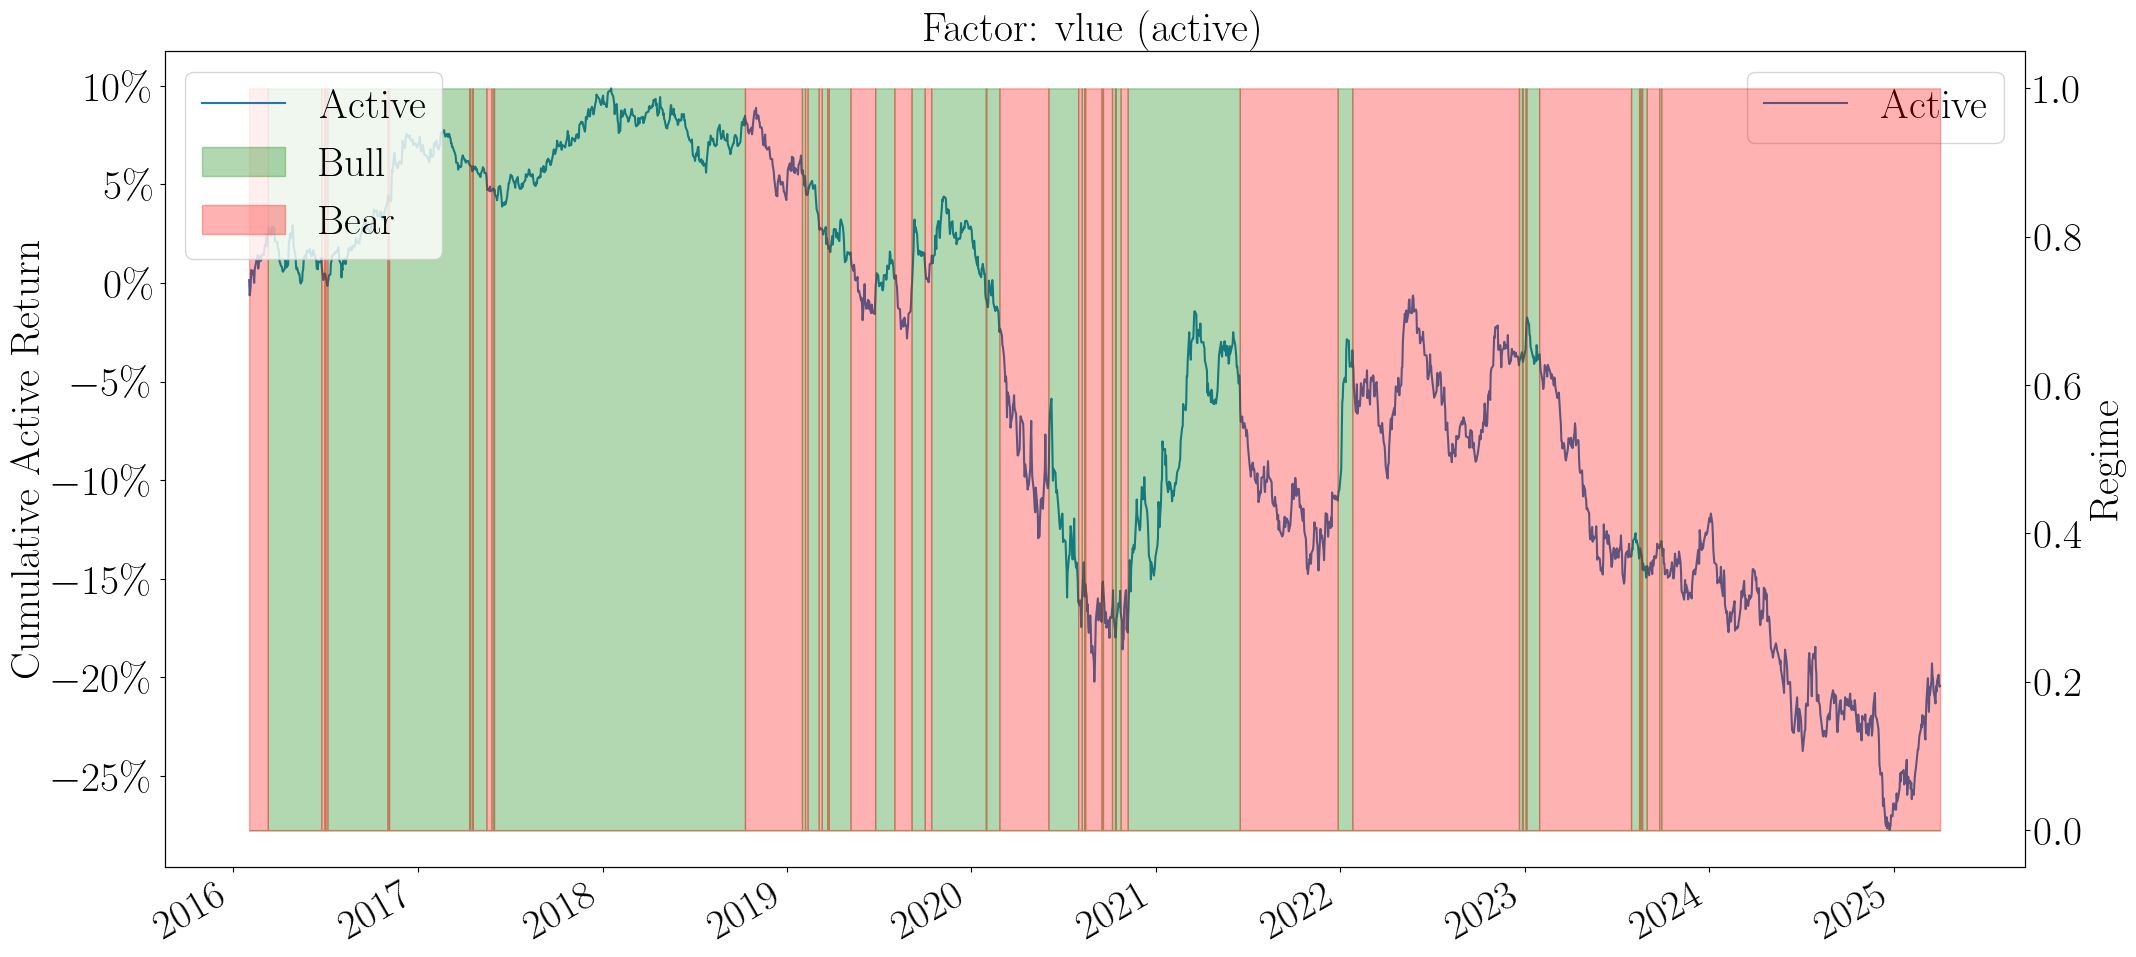

In [ ]:
import matplotlib.pyplot as plt
from jumpmodels.plot import plot_regimes_and_cumret

for fac in factors:
    regimes     = factor_views[fac]["state"].dropna().astype(int)
    ret_raw     = factor_data_dict[fac]["fac_ret"].dropna()
    ret_active  = factor_data_dict[fac]["active_ret"].dropna()

    idx_raw    = regimes.index.intersection(ret_raw.index)
    idx_active = regimes.index.intersection(ret_active.index)


    ax_raw, _ = plot_regimes_and_cumret(
        regimes.loc[idx_raw],
        ret_raw.loc[idx_raw],
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        legend_loc='upper left'
    )
    ax_raw.set_title(f"Factor: {fac}")
    plt.show()


    ax_act, _ = plot_regimes_and_cumret(
        regimes.loc[idx_active],
        ret_active.loc[idx_active].to_frame("Active"),
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        ylabel_ret="Cumulative Active Return",
        legend_loc='upper left'
    )
    ax_act.set_title(f"Factor: {fac} (active)")
    plt.show()

    
